In [472]:
# read cities.txt (id, lat, lon) and plot every city on a map
import matplotlib.pyplot as plt
import numpy as np
from math import radians, cos, sin, sqrt, atan2
import networkx as nx
import pandas as pd
import os, time, sys, random, math, heapq
from concurrent.futures import ThreadPoolExecutor
import itertools as it
import scienceplots
from collections import deque
from matplotlib import animation
from IPython.display import Video, display
import re
from tqdm import tqdm, trange

In [394]:
# plt theme latex
plt.style.use(['science','no-latex'])
# size of the plot
plt.rcParams["figure.figsize"] = (6*0.6, 4*0.6)

# dpi
plt.rcParams["figure.dpi"] = 600

## Part 1: Get Data

In [395]:
# read us-cities-top-1k.csv
df = pd.read_csv('us-cities-top-1k.csv') # cols = ['City', 'State', 'Population', 'lat', 'lon']
# sort by population
df = df.sort_values(by='Population', ascending=False)

with open('cities.txt', 'w') as f:
    for idx, (i, row) in enumerate(df.iterrows()):
        f.write(f'{row["City"].replace(" ", "_")} {row["lat"]:.2f} {row["lon"]:.2f} {row["Population"]}\n')
        # if idx > 10000:
        #     break

In [435]:
def read_cities(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    cities = []
    for line in lines:
        name, lat, lon, pop = line.split()
        cities.append((name, float(lat), float(lon), int(pop)))
    print(f"Read {len(cities)} cities from {filename}")
    return cities

def remove_outliers(cities):
    lats = [x[1] for x in cities]
    lons = [x[2] for x in cities]
    lat_mean = np.mean(lats)
    lat_std = np.std(lats)
    lon_mean = np.mean(lons)
    lon_std = np.std(lons)
    cities = list(filter(lambda x: abs(x[1] - lat_mean) < 3 * lat_std and abs(x[2] - lon_mean) < 3 * lon_std, cities))
    return cities

def map_range(x, in_min, in_max, out_min, out_max):
  if in_max == in_min:
    return (out_max + out_min) // 2
  return (x - in_min) * (out_max - out_min) // (in_max - in_min) + out_min

def plot_cities(cities):
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    plt.scatter(lons, lats, s=norm_pops, c="red")  # Using scatter for variable markersize
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Locations of Cities")
    plt.show()
    

Read 1000 cities from cities.txt


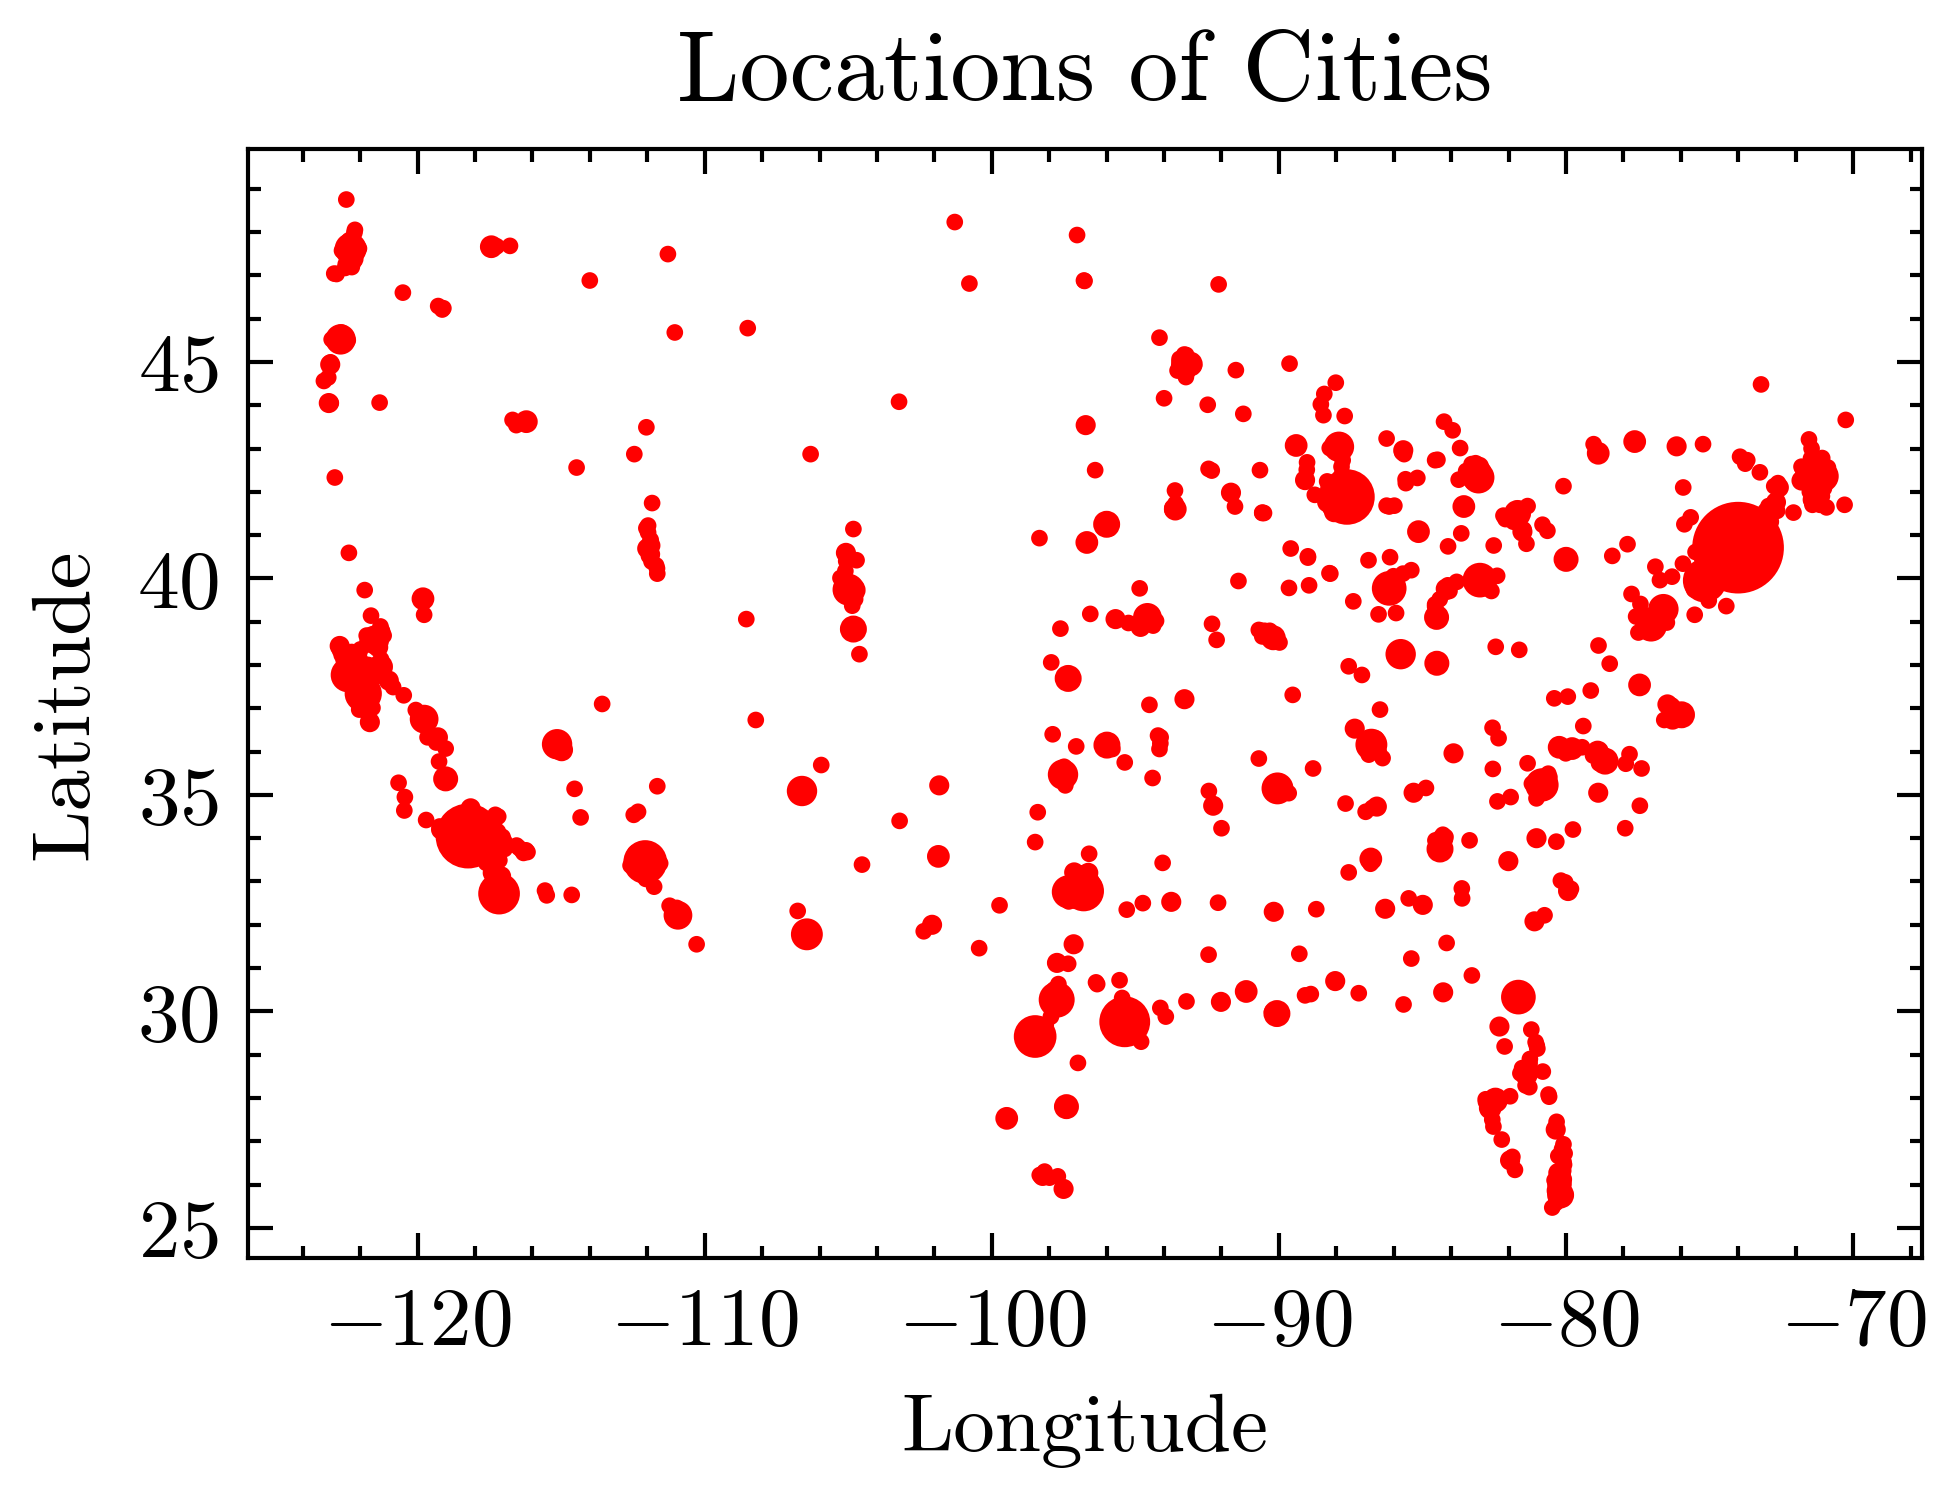

In [436]:
cities = read_cities("cities.txt")
cities = remove_outliers(cities)
plot_cities(cities)

In [447]:
def distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c # distance in km

def l2_distance(lat1, lon1, lat2, lon2):
    return math.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)


# Determine how redundant each city is based on other cities
def redundancy_1(cities, weight=2):
    r = np.zeros(len(cities))
    for i in range(len(cities)):
        for j in range(i + 1, len(cities)):
            ci = cities[i]
            cj = cities[j]
            lat1, lon1 = ci[1], ci[2]
            lat2, lon2 = cj[1], cj[2]
            d = distance(lat1, lon1, lat2, lon2)
            p1, p2 = ci[3], cj[3]
            # rscore = p2 / p1 * d ** -weight
            # rscore = np.log(rscore)
            rscore = np.log(p2 / p1) - weight * np.log(d)
            if p1 > p2:
                # r[j] += rscore
                # numpy log add trick
                r[j] = np.logaddexp(r[j], rscore)
            elif p2 > p1:
                r[i] = np.logaddexp(r[i], rscore)
    return r
    

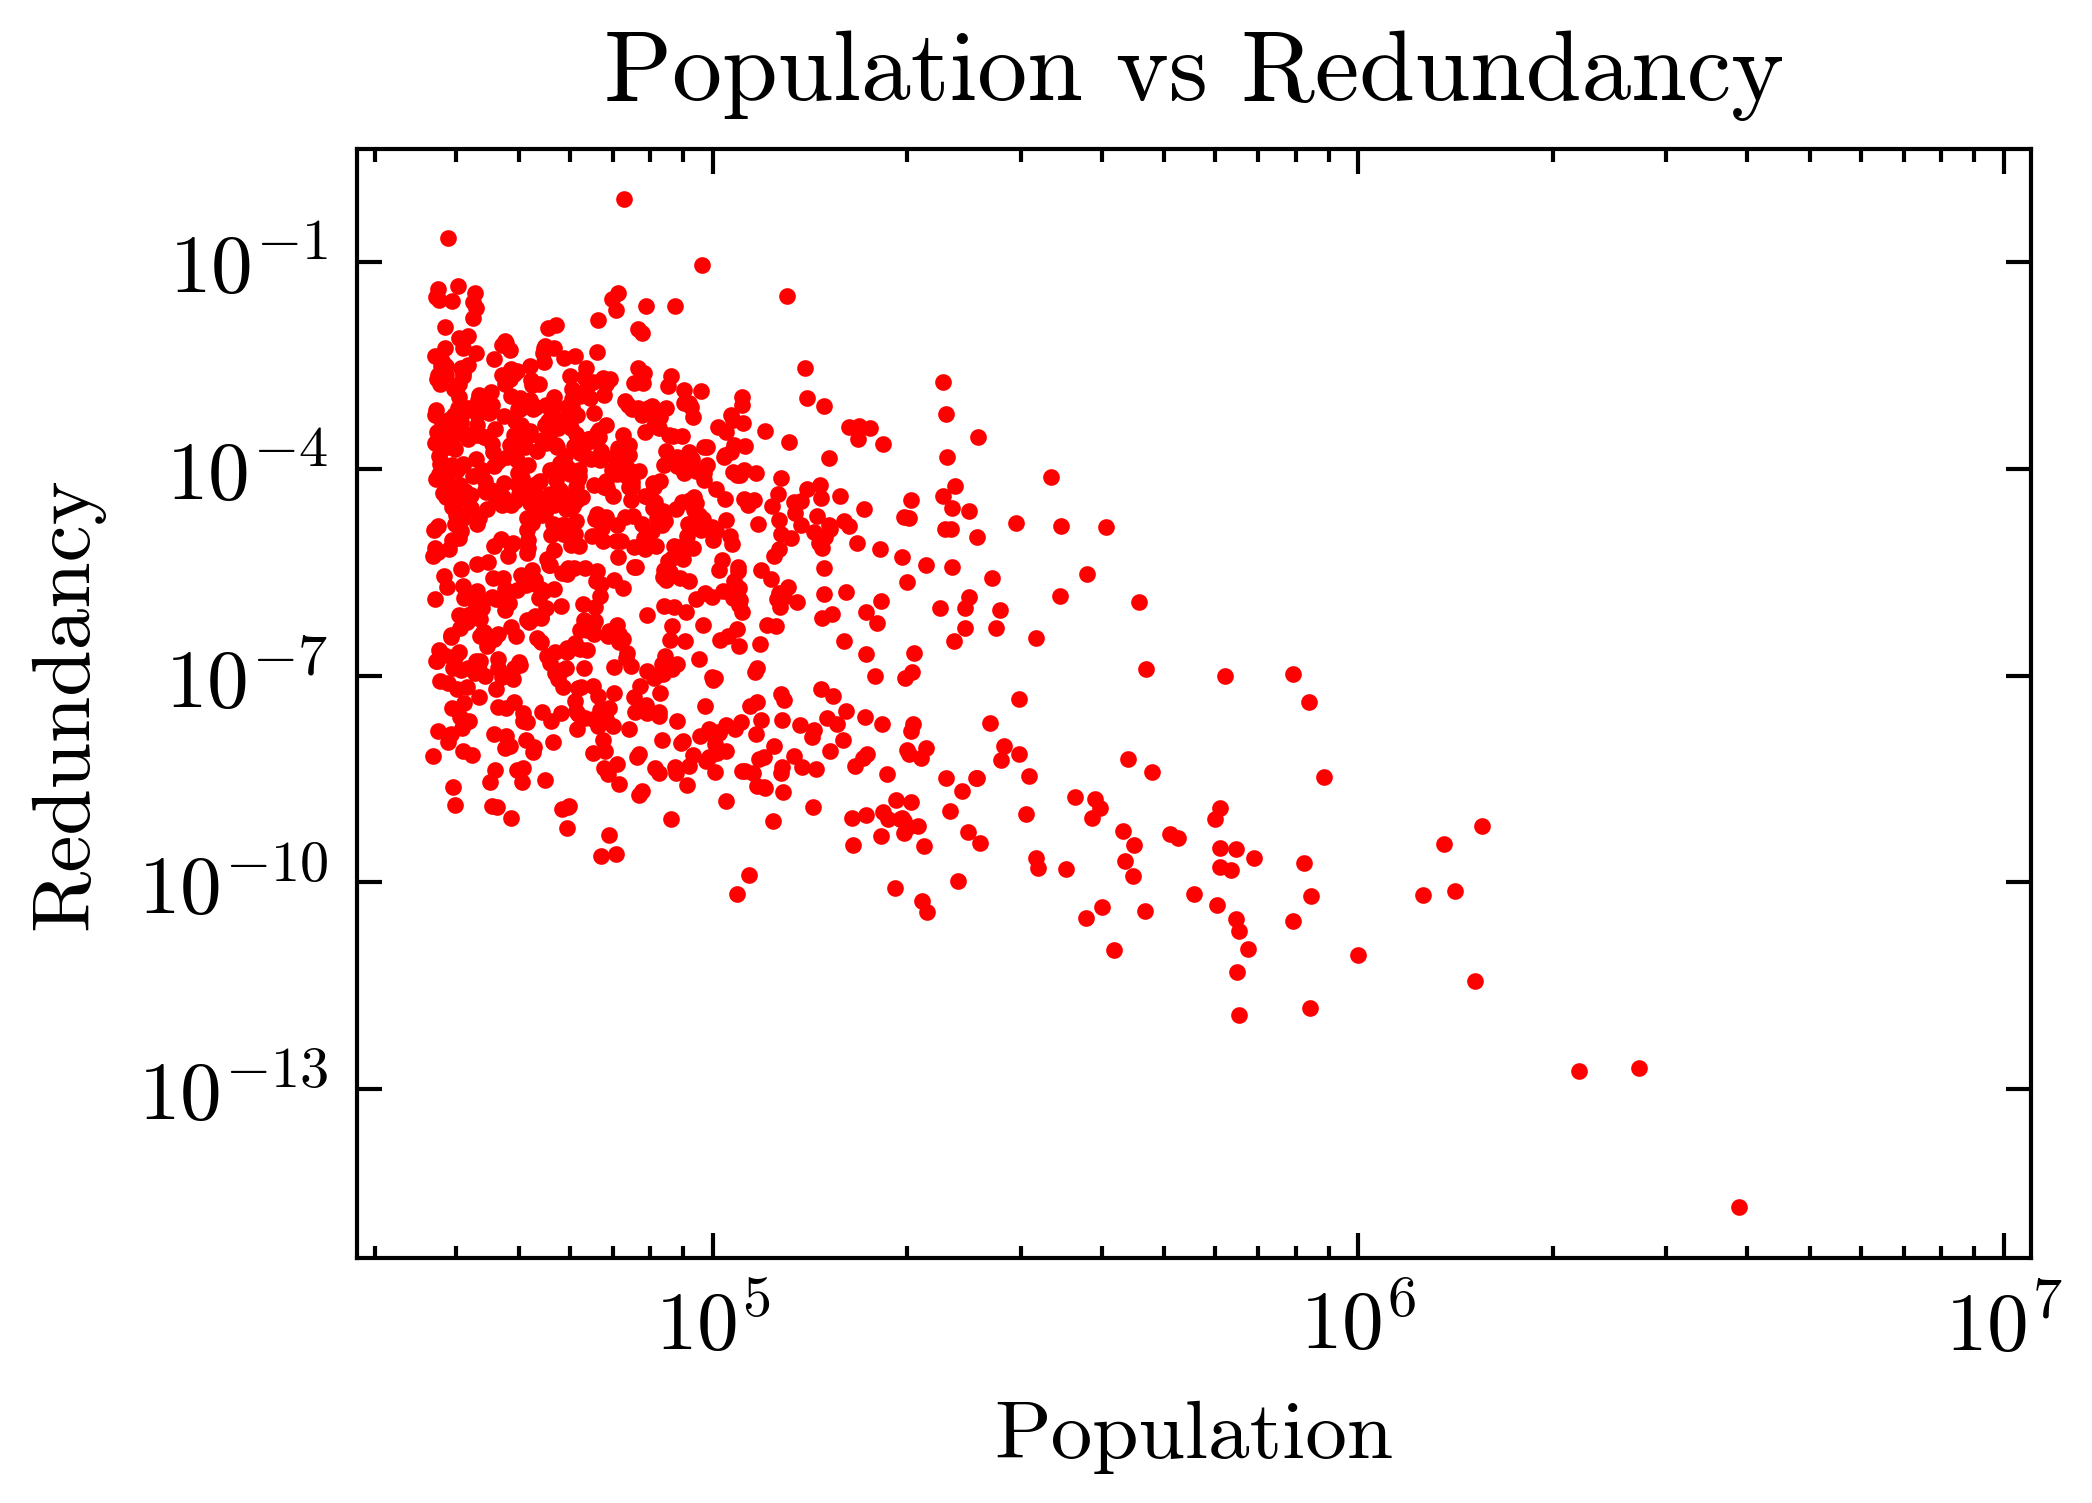

In [448]:
# keep the 100 most redundant cities
scores = redundancy_1(cities, 4)
pops = [x[3] for x in cities]
# plot graph between redundancy and population
plt.scatter(pops, scores, c="red", s=1)
plt.xlabel("Population")
plt.ylabel("Redundancy")
plt.yscale("log")
plt.xscale("log")
plt.title("Population vs Redundancy")
plt.show()

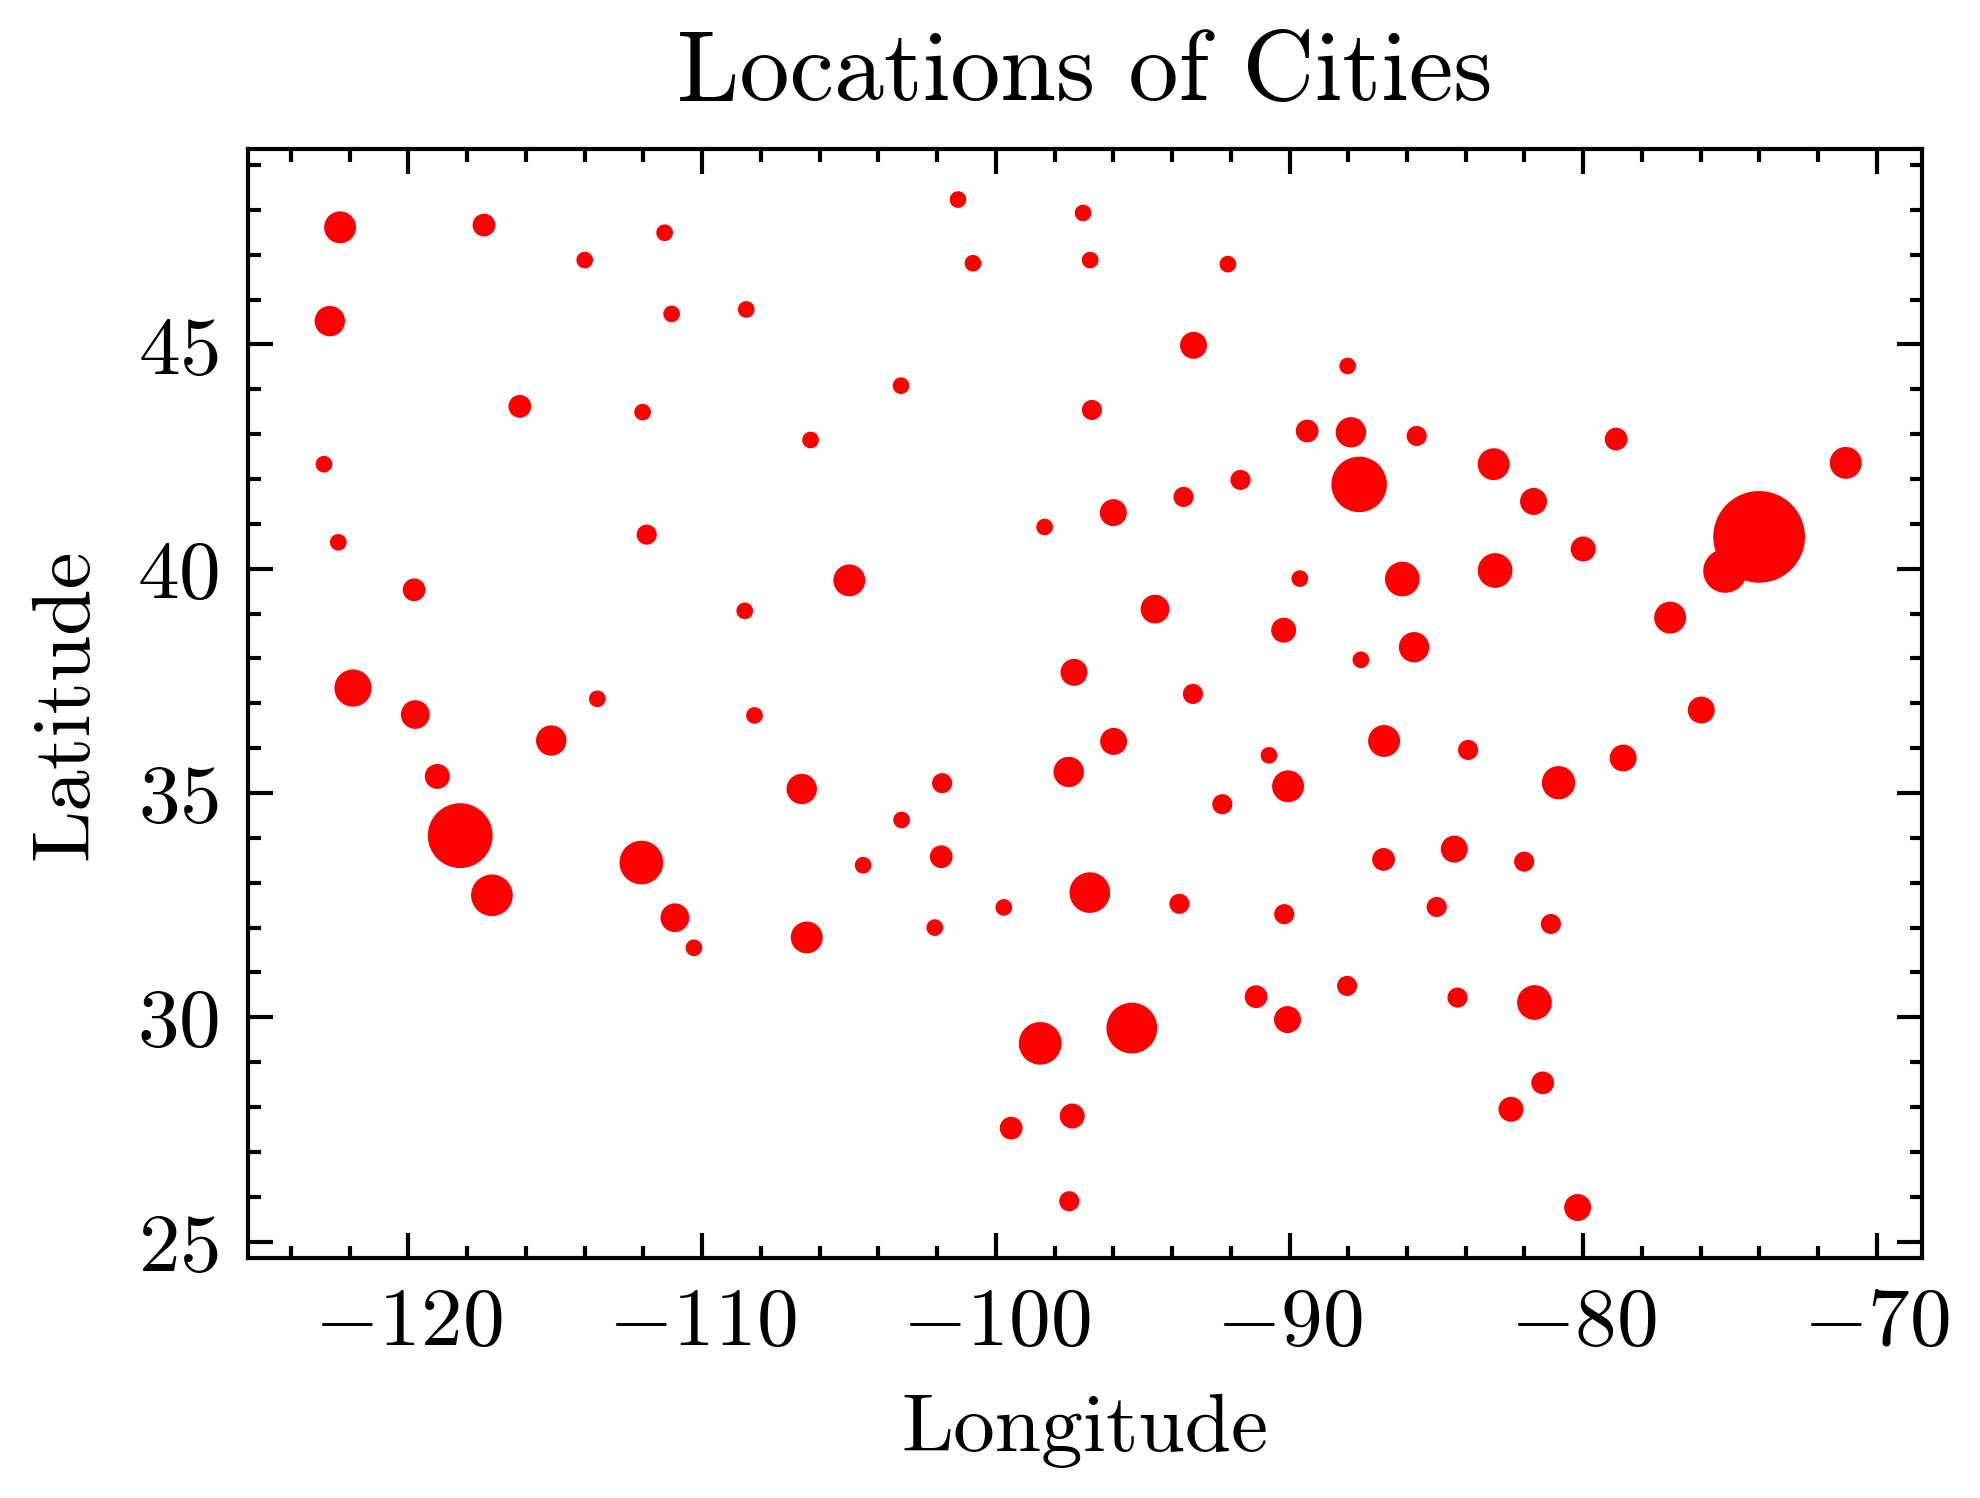

In [495]:
# keep the 100 least redundant cities
cities1 = [cities[i] for i in np.argsort(scores)[:100]]
plot_cities(cities1)

## Part 2: Algorithm

In [450]:
cities1[:5]

[('New_York', 40.71, -74.01, 8405837),
 ('Los_Angeles', 34.05, -118.24, 3884307),
 ('Houston', 29.76, -95.37, 2195914),
 ('Chicago', 41.88, -87.63, 2718782),
 ('Seattle', 47.61, -122.33, 652405)]

In [451]:
# get path length
def path_length(cities, p, full=False, distance=distance):
    length = 0
    for i in range(len(p) - 1):
        c1 = cities[p[i]]
        c2 = cities[p[i + 1]]
        length += distance(c1[1], c1[2], c2[1], c2[2])
    if full:
        length += distance(cities[p[0]][1], cities[p[0]][2], cities[p[-1]][1], cities[p[-1]][2])
    return length

In [498]:
def plot_cities_permutation(cities, p):
    # get path length
    length = path_length(cities, p)
    # Extract cities in the order specified by permutation p
    permuted_cities = [cities[i] for i in p]
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    
    # Create the plot
    fig, ax = plt.subplots()
    # fig.set_tight_layout(True)
    # ax.set_aspect('equal', adjustable='datalim')

    # Plot the cities as points
    scatter = ax.scatter(lons, lats, s=norm_pops, c="red")
    
    # Connect the cities in the order specified by permutation p
    line, = ax.plot(lons, lats, linestyle='-', color='blue', linewidth=0.25)
    
    # Adding titles and subtitle
    title = ax.text(0.5, 1.18, "Shortest Tour of Cities (TSP)", transform=ax.transAxes, ha="center", fontsize=12)
    subtitle = ax.text(0.5, 1.05, f"Length: {length:,.2f} km", transform=ax.transAxes, ha="center", fontsize=10)
    
    # Adding labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # make x and y scales equal
    # ax.set_aspect('equal', adjustable='datalim')

    # Automatically adjust limits
    # plt.autoscale()
    plt.show()


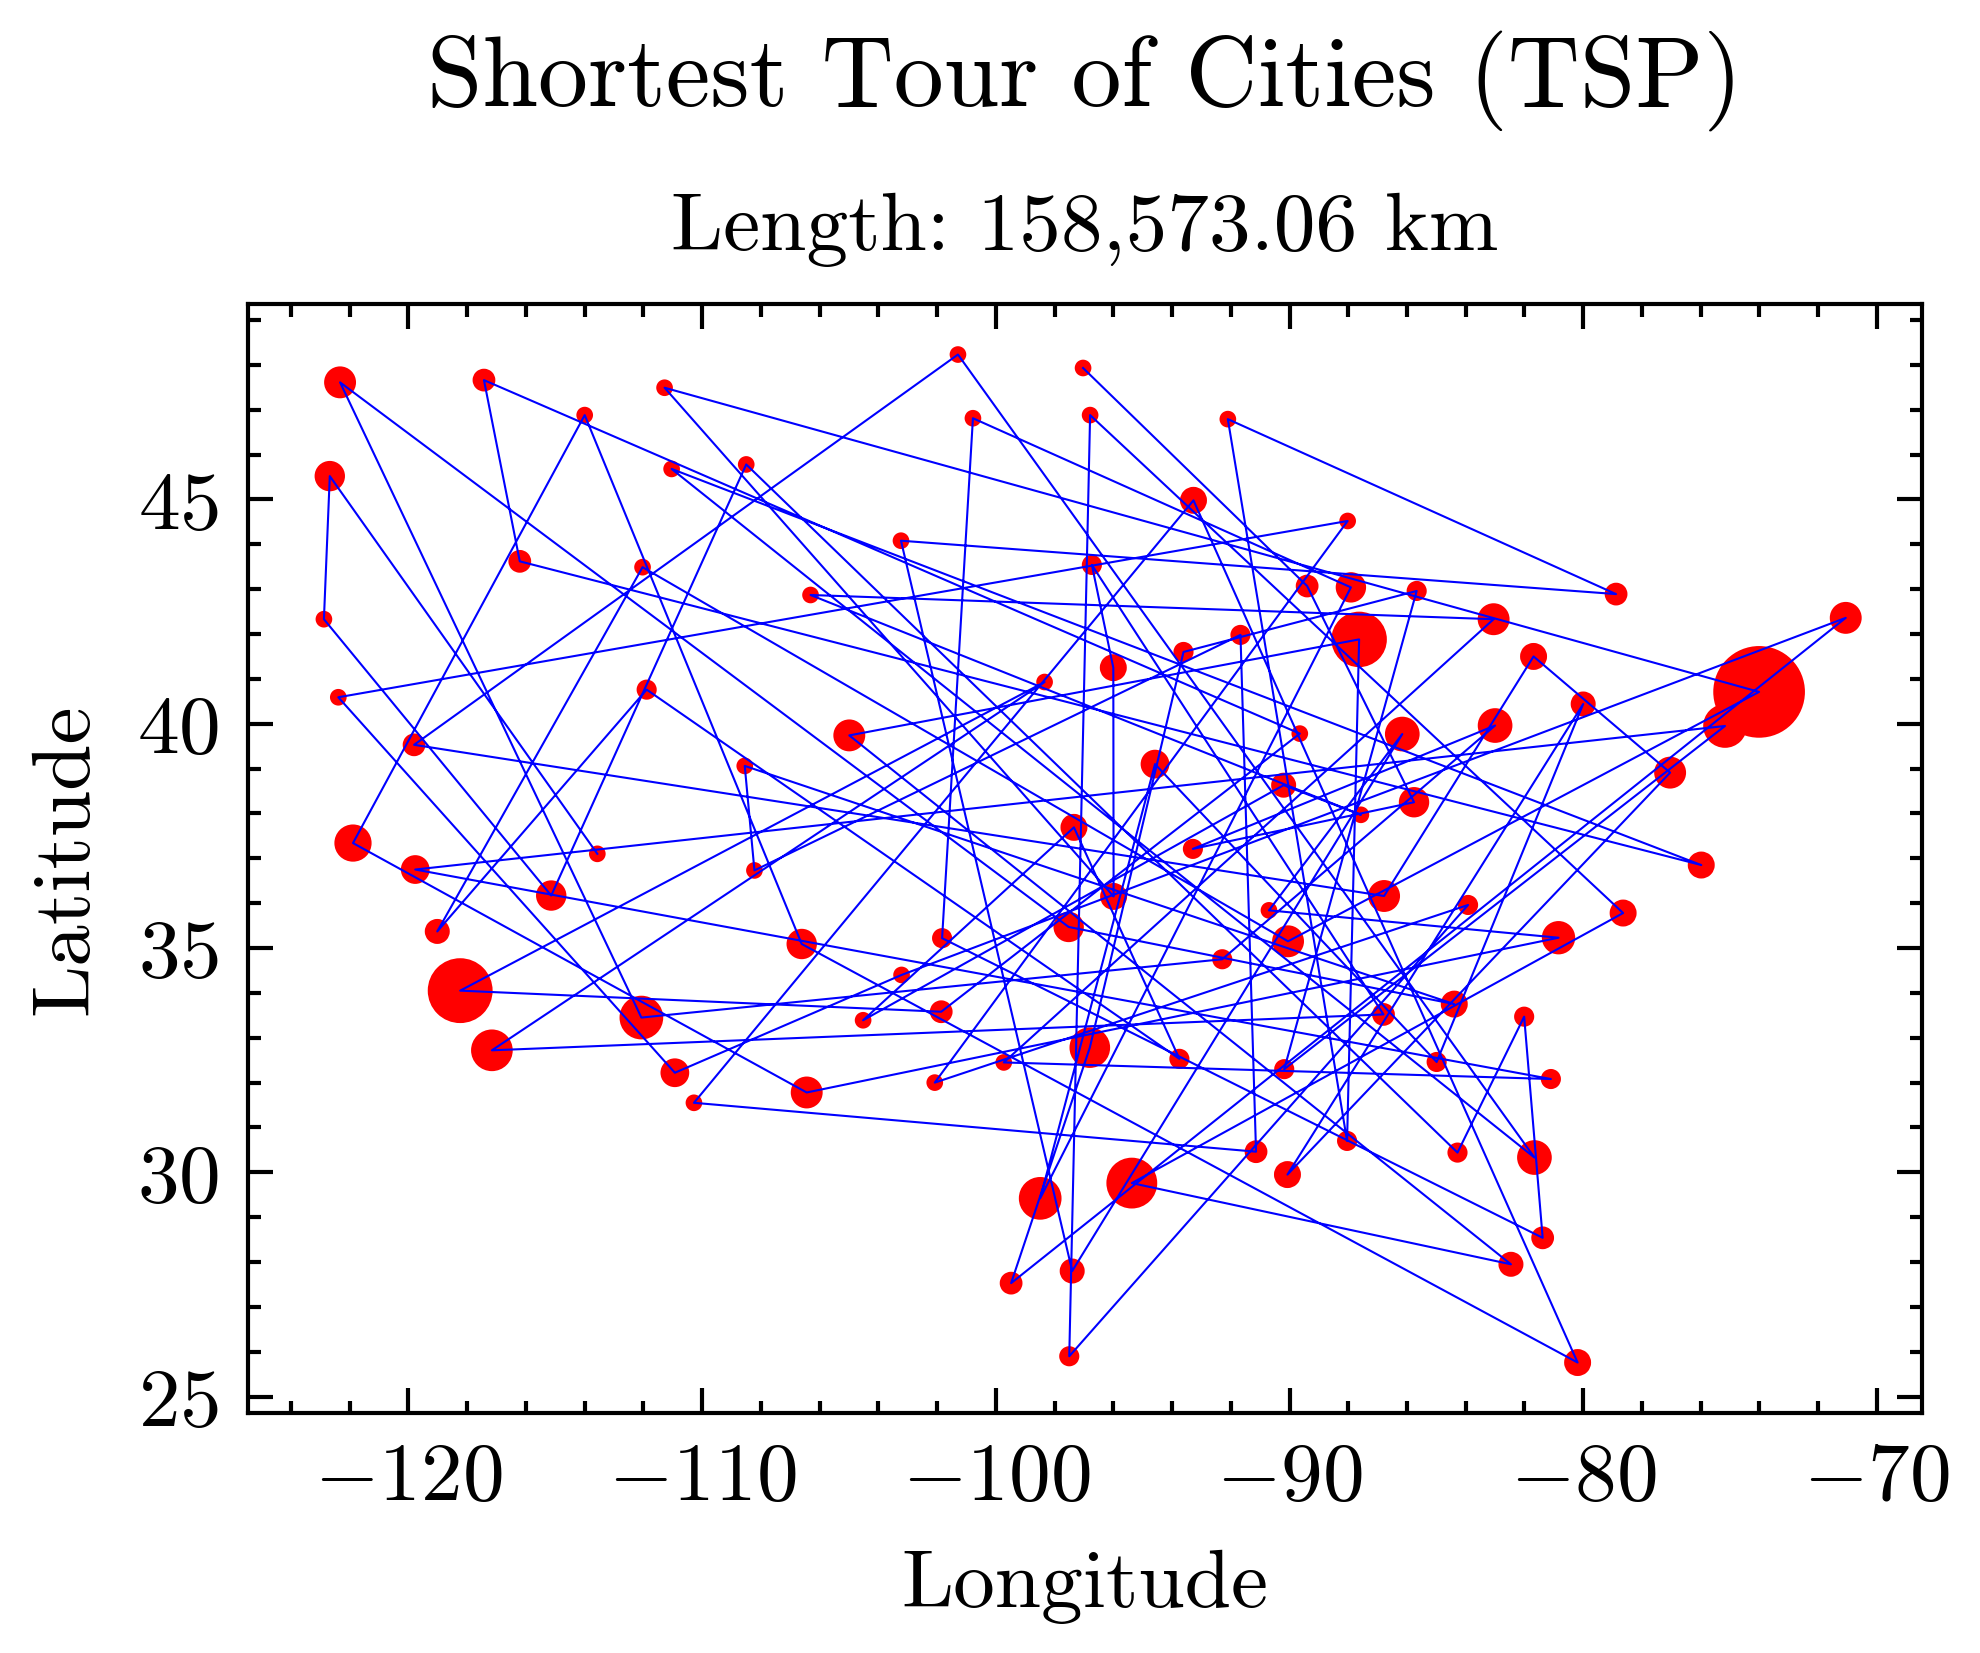

In [499]:
p = np.random.permutation(len(cities1))
plot_cities_permutation(cities1, p)

In [475]:
def ordered_crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end] = parent1[start:end]
    ptr = end
    for i in range(size):
        if parent2[(end + i) % size] not in child:
            child[ptr % size] = parent2[(end + i) % size]
            ptr += 1
    return child


def mutate(permutation, mutation_rate=0.01):
    l = len(permutation)  # subtract 1 because the last city is the same as the first city
    for i in range(l):
        if random.random() < mutation_rate:
            j = random.randint(0, l - 1)
            permutation[i], permutation[j] = permutation[j], permutation[i]


def genetic_algorithm(
    cities,
    population_size=100,
    generations=500,
    mutation_rate=0.01,
    mutation_decay_factor=1,
    r=0.1,
    full=True,
    initial_population=None,
    early_stopping_generations=10,
    cpu_count=None,
):
    assert 0 <= r <= 1
    assert population_size > 4
    _r = repr(
        {
            "population_size": population_size,
            "generations": generations,
            "mutation_rate": mutation_rate,
            "mutation_decay_factor": mutation_decay_factor,
            "r": r,
            "full": full,
            "initial_population": initial_population,
            "early_stopping_generations": early_stopping_generations,
            "cpu_count": cpu_count,
        }
    )
    print(f"Running genetic_algorithm with parameters: {_r}")

    # create a tmp directory to save results while running
    fn = f"tmp/geneticalgorithm/{time.strftime('%Y%m%d-%H%M%S')}"
    os.makedirs(fn, exist_ok=True)
    print(f"Saving results to {fn}")

    # Initialize population
    population = []
    if initial_population is not None:
        population.extend(initial_population)

    population += [np.random.permutation(len(cities)) for _ in range(population_size - len(population))]
    best_fitness = float("inf")
    fitness_history = []

    with ThreadPoolExecutor(max_workers=cpu_count) as executor:
        history = []
        with open(f"{fn}/log.txt", "w") as f:
            last_time = time.time()
            for generation in (bar := trange(generations)):
                # Calculate fitness
                fitness = list(executor.map(lambda p: path_length(cities, p, full=full), population))
                fitness_history.append(fitness)
                current_best_fitness = min(fitness)
                if current_best_fitness < best_fitness:
                    best_fitness = current_best_fitness


                # print(
                #     f"Generation {generation + 1}/{generations} (Fitness: {min(fitness):.2f} - {max(fitness):.2f} - {np.mean(fitness):.2f})",
                #     end="\r",
                # )
                bar.set_description(f"Generation {generation + 1}/{generations} (Fitness: {min(fitness):.2f} - {max(fitness):.2f} - {np.mean(fitness):.2f})")
                sorted_indices = np.argsort(fitness)
                population = [population[i] for i in sorted_indices]

                # Save the best solution found so far
                history.append((generation, min(fitness), population[0]))
                print(f"{generation} {min(fitness):.2f} {population[0]}", file=f)
                curr_time = time.time()
                if curr_time - last_time > 4:
                    f.flush()
                last_time = curr_time

                if (generation + 1) % 20 == 0:
                    print()  # Print a newline every 10 generations
                # Early stopping criteria (if the fitness does not improve over 10 generations)
                if early_stopping_generations > -1:
                    if generation > early_stopping_generations and min(fitness_history[-1]) == min(
                        fitness_history[-early_stopping_generations]
                    ):
                        print()
                        print(f"Early stopping at generation {generation + 1}")
                        break

                # Selection
                num_best_to_keep = int(r * population_size)
                new_population = population[:num_best_to_keep]

                # Crossover and Mutation
                def crossover_and_mutate(parents):
                    child = ordered_crossover(parents[0], parents[1])
                    mutate(child, mutation_rate * mutation_decay_factor**generation)
                    return child

                parents_pairs = [
                    random.sample(population[: population_size // 2], 2)
                    for _ in range(population_size - num_best_to_keep)
                ]
                new_children = list(executor.map(crossover_and_mutate, parents_pairs))
                new_population.extend(new_children)

                population = new_population

    # Return the best solution found
    best_solution = population[0]
    best_length = path_length(cities, best_solution, full=full)
    if full:
        best_solution += best_solution[:1]
    return best_solution, best_length, history

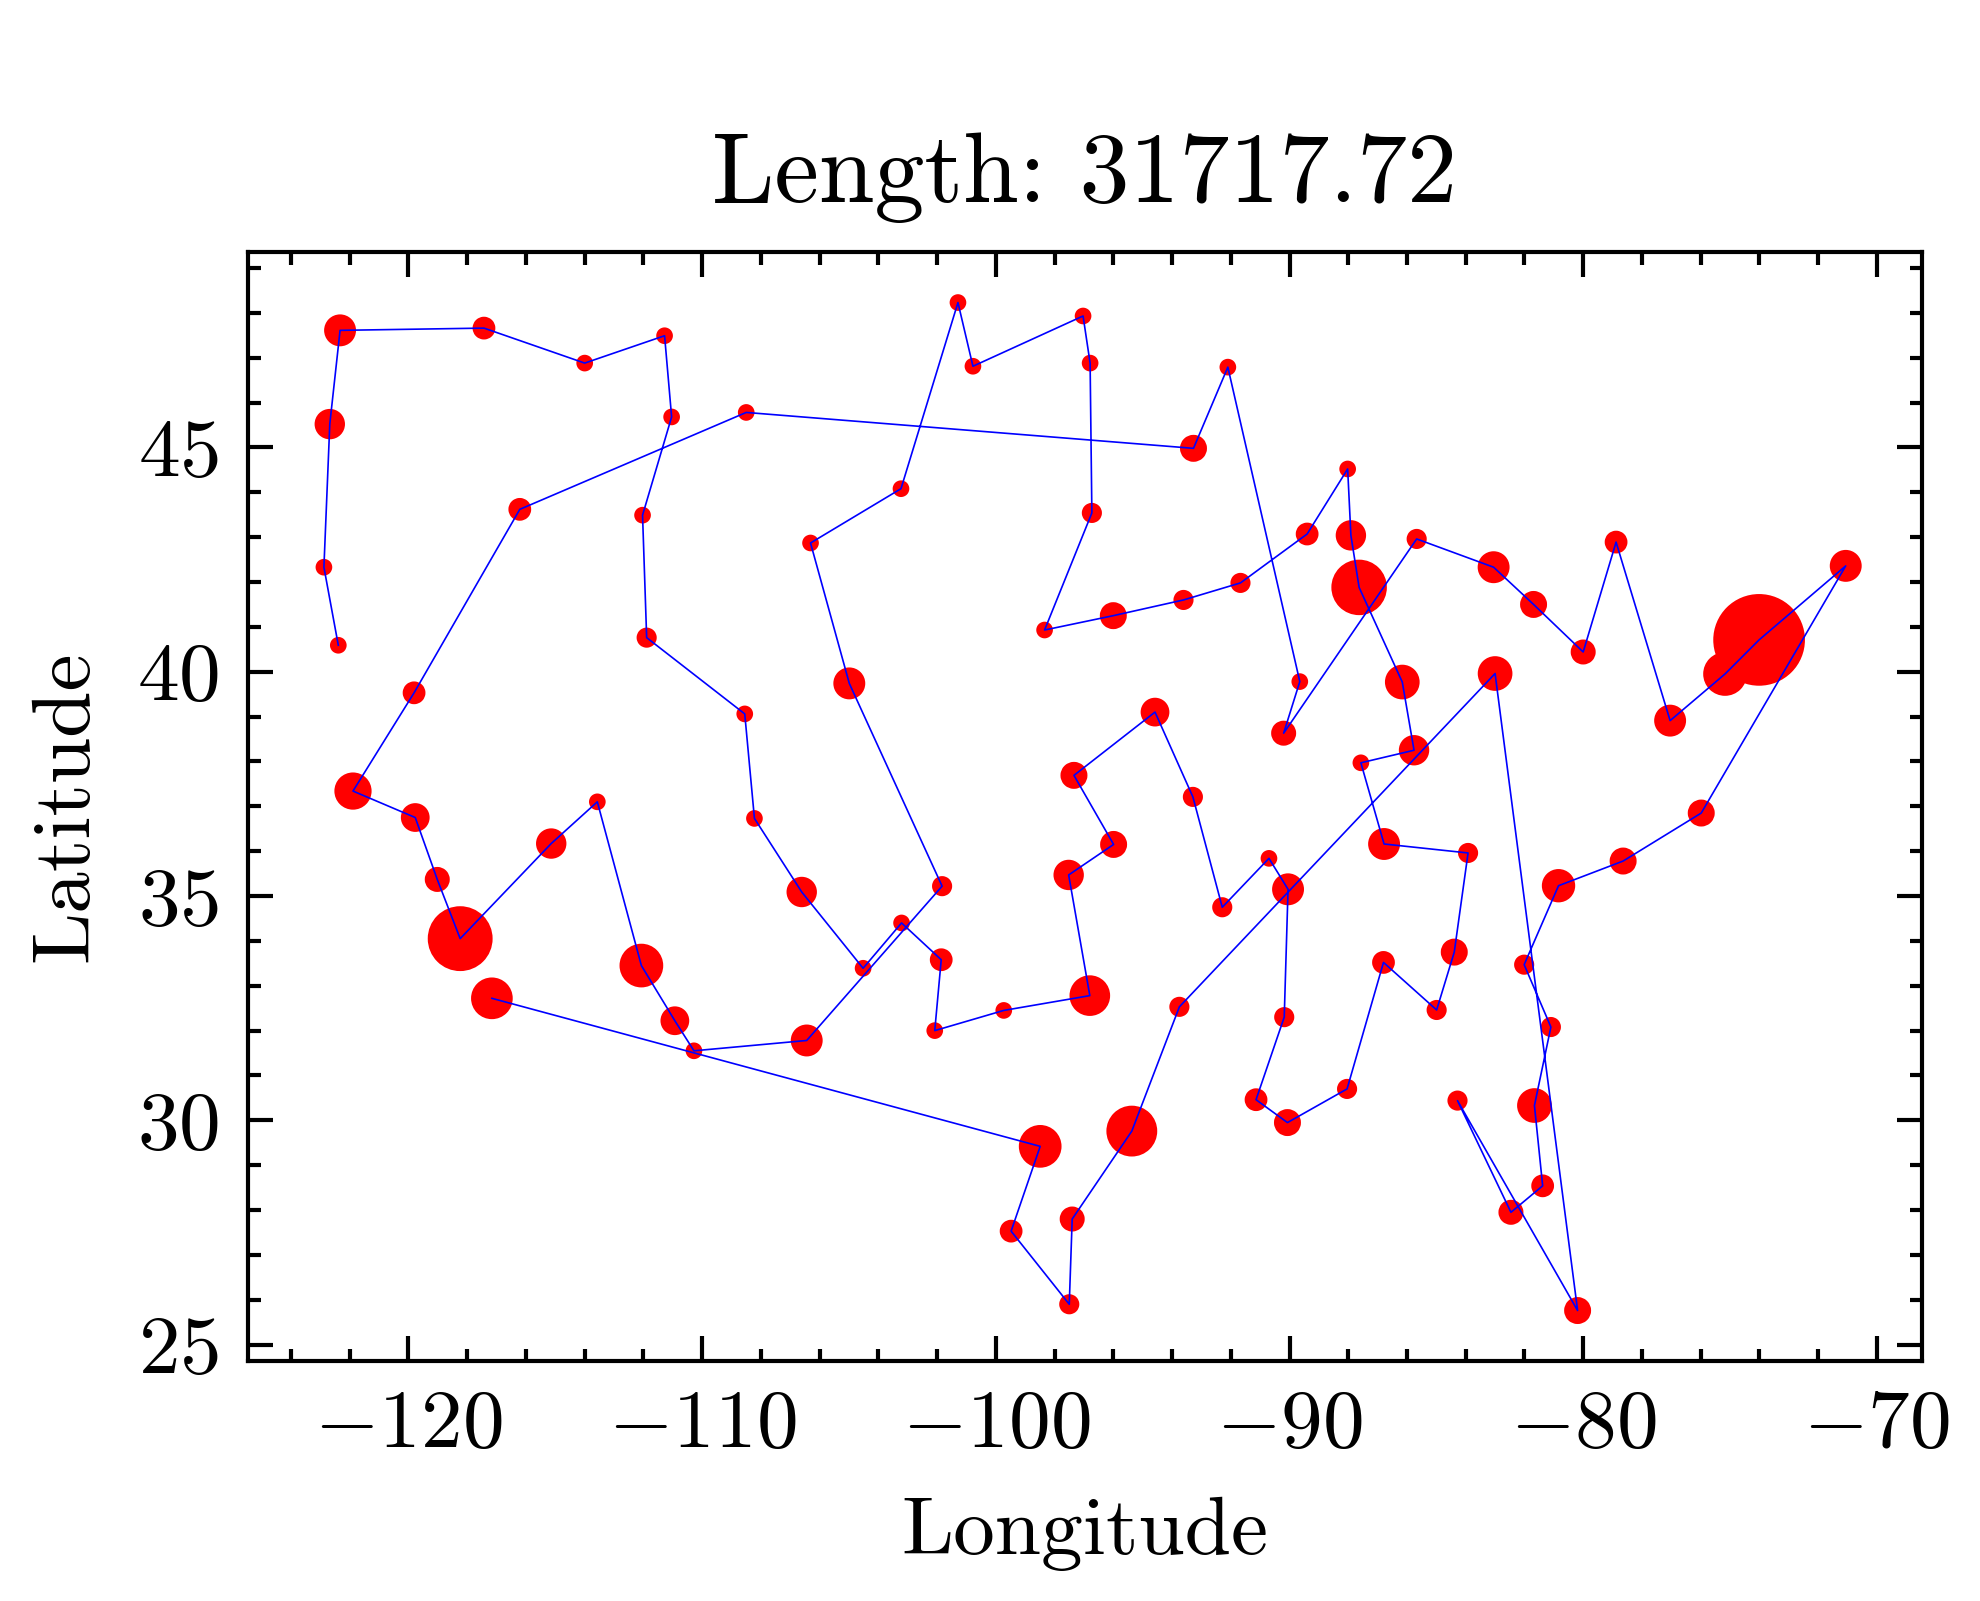

In [454]:
def nearest_neighbor(cities):
    n = len(cities)
    unvisited = set(range(n))
    current = random.choice(list(unvisited))
    unvisited.remove(current)
    path = [current]
    while unvisited:
        current = min(unvisited, key=lambda x: l2_distance(cities[x][1], cities[x][2], cities[path[-1]][1], cities[path[-1]][2]))
        unvisited.remove(current)
        path.append(current)
    return path

plot_cities_permutation(cities1, nearest_neighbor(cities1))

In [507]:
# Run the genetic algorithm
best_permutation, best_length, hist = genetic_algorithm(
    cities1,
    mutation_rate=1e-3,
    mutation_decay_factor=0.1 ** (1 / 5000),
    generations=20000,
    r=0.32,
    population_size=500,
    early_stopping_generations=10000,
)

Running genetic_algorithm with parameters: {'population_size': 500, 'generations': 20000, 'mutation_rate': 0.001, 'mutation_decay_factor': 0.9995395890030878, 'r': 0.32, 'full': True, 'initial_population': None, 'early_stopping_generations': 10000, 'cpu_count': None}
Saving results to tmp/geneticalgorithm/20240704-223046


Generation 21/20000 (Fitness: 106235.65 - 134091.30 - 117932.57):   0%|          | 20/20000 [00:03<55:37,  5.99it/s]  

Generation 41/20000 (Fitness: 91876.81 - 116487.26 - 100335.68):   0%|          | 40/20000 [00:07<54:45,  6.07it/s] 

Generation 61/20000 (Fitness: 80281.39 - 102109.78 - 88619.26):   0%|          | 60/20000 [00:10<55:06,  6.03it/s]  

Generation 81/20000 (Fitness: 74443.98 - 103715.40 - 82247.55):   0%|          | 80/20000 [00:13<54:33,  6.08it/s]

Generation 101/20000 (Fitness: 67638.23 - 87005.48 - 73946.55):   0%|          | 100/20000 [00:17<54:12,  6.12it/s] 

Generation 121/20000 (Fitness: 60440.93 - 80051.39 - 67658.33):   1%|          | 120/20000 [00:20<1:04:05,  5.17it/s]

Generation 141/20000 (Fitness: 55780.50 - 75755.09 - 61928.92):   1%|          | 140/20000 [00:24<54:13,  6.10it/s]  

Generation 161/20000 (Fitness: 52580.84 - 76010.34 - 58390.61):   1%|          | 160/20000 [00:27<1:11:37,  4.62it/s]

Generation 181/20000 (Fitness: 49579.22 - 78886.87 - 55226.86):   1%|          | 180/20000 [00:31<53:20,  6.19it/s]  

Generation 201/20000 (Fitness: 44953.29 - 61671.89 - 50838.97):   1%|          | 200/20000 [00:34<58:09,  5.67it/s]  

Generation 221/20000 (Fitness: 41298.40 - 59134.00 - 45709.48):   1%|          | 220/20000 [00:37<53:21,  6.18it/s]

Generation 241/20000 (Fitness: 39243.63 - 59044.81 - 42387.83):   1%|          | 240/20000 [00:41<55:34,  5.93it/s]  

Generation 261/20000 (Fitness: 37519.30 - 50026.82 - 40201.63):   1%|▏         | 260/20000 [00:44<52:10,  6.30it/s]

Generation 281/20000 (Fitness: 34619.25 - 56670.03 - 37123.69):   1%|▏         | 280/20000 [00:48<52:36,  6.25it/s]  

Generation 302/20000 (Fitness: 33111.29 - 46231.67 - 34619.88):   2%|▏         | 301/20000 [00:51<51:39,  6.35it/s]

Generation 321/20000 (Fitness: 32198.83 - 45426.98 - 32869.35):   2%|▏         | 320/20000 [00:54<50:33,  6.49it/s]  

Generation 341/20000 (Fitness: 31828.05 - 45538.01 - 32268.14):   2%|▏         | 340/20000 [00:57<50:34,  6.48it/s]

Generation 361/20000 (Fitness: 31640.18 - 45845.87 - 32071.08):   2%|▏         | 360/20000 [01:01<50:34,  6.47it/s]  

Generation 381/20000 (Fitness: 31045.21 - 42156.05 - 31739.77):   2%|▏         | 380/20000 [01:04<50:32,  6.47it/s]

Generation 401/20000 (Fitness: 30463.78 - 43201.36 - 31231.13):   2%|▏         | 400/20000 [01:07<50:46,  6.43it/s]  

Generation 421/20000 (Fitness: 30033.25 - 42939.46 - 30522.09):   2%|▏         | 420/20000 [01:10<1:02:43,  5.20it/s]

Generation 441/20000 (Fitness: 30033.25 - 39740.46 - 30273.49):   2%|▏         | 440/20000 [01:13<50:18,  6.48it/s]  

Generation 462/20000 (Fitness: 29709.27 - 41681.78 - 30372.10):   2%|▏         | 461/20000 [01:17<53:18,  6.11it/s]  

Generation 482/20000 (Fitness: 29540.11 - 41427.18 - 29852.49):   2%|▏         | 482/20000 [01:19<31:00, 10.49it/s]

Generation 502/20000 (Fitness: 29238.08 - 41935.79 - 29683.91):   2%|▎         | 500/20000 [01:21<35:46,  9.09it/s]

Generation 522/20000 (Fitness: 28915.07 - 38611.42 - 29436.62):   3%|▎         | 521/20000 [01:23<33:03,  9.82it/s]

Generation 542/20000 (Fitness: 28703.86 - 41368.59 - 29152.62):   3%|▎         | 541/20000 [01:25<33:19,  9.73it/s]

Generation 562/20000 (Fitness: 28531.59 - 40557.39 - 28686.31):   3%|▎         | 561/20000 [01:27<30:51, 10.50it/s]

Generation 582/20000 (Fitness: 28531.59 - 43557.03 - 28851.95):   3%|▎         | 581/20000 [01:29<32:25,  9.98it/s]

Generation 602/20000 (Fitness: 28531.59 - 41009.48 - 28874.00):   3%|▎         | 601/20000 [01:31<30:19, 10.66it/s]

Generation 622/20000 (Fitness: 28511.47 - 43667.62 - 28969.05):   3%|▎         | 621/20000 [01:33<30:39, 10.53it/s]

Generation 642/20000 (Fitness: 28511.47 - 37890.36 - 28656.62):   3%|▎         | 641/20000 [01:35<30:03, 10.73it/s]

Generation 662/20000 (Fitness: 28511.47 - 48837.15 - 28814.01):   3%|▎         | 661/20000 [01:37<30:40, 10.51it/s]

Generation 681/20000 (Fitness: 28511.47 - 42044.06 - 28773.08):   3%|▎         | 679/20000 [01:39<30:07, 10.69it/s]

Generation 702/20000 (Fitness: 28511.47 - 43356.98 - 28757.56):   4%|▎         | 702/20000 [01:41<30:07, 10.68it/s]

Generation 722/20000 (Fitness: 28187.01 - 40155.38 - 28717.93):   4%|▎         | 722/20000 [01:43<34:45,  9.24it/s]

Generation 742/20000 (Fitness: 28187.01 - 40183.31 - 28434.51):   4%|▎         | 742/20000 [01:45<30:07, 10.66it/s]

Generation 762/20000 (Fitness: 28187.01 - 41111.47 - 28396.68):   4%|▍         | 760/20000 [01:47<34:31,  9.29it/s]

Generation 782/20000 (Fitness: 28187.01 - 42211.12 - 28376.77):   4%|▍         | 782/20000 [01:49<30:13, 10.60it/s]

Generation 802/20000 (Fitness: 28187.01 - 41997.46 - 28429.49):   4%|▍         | 801/20000 [01:51<32:46,  9.76it/s]

Generation 822/20000 (Fitness: 28187.01 - 35680.00 - 28292.51):   4%|▍         | 821/20000 [01:53<30:57, 10.33it/s]

Generation 842/20000 (Fitness: 28187.01 - 47181.82 - 28451.29):   4%|▍         | 841/20000 [01:55<31:35, 10.11it/s]

Generation 862/20000 (Fitness: 28187.01 - 52150.31 - 28506.47):   4%|▍         | 861/20000 [01:57<31:38, 10.08it/s]

Generation 882/20000 (Fitness: 28187.01 - 41468.74 - 28499.61):   4%|▍         | 881/20000 [01:59<31:01, 10.27it/s]

Generation 902/20000 (Fitness: 28187.01 - 42991.14 - 28452.24):   5%|▍         | 902/20000 [02:01<39:31,  8.05it/s]

Generation 922/20000 (Fitness: 28187.01 - 40824.94 - 28433.84):   5%|▍         | 921/20000 [02:03<30:45, 10.34it/s]

Generation 943/20000 (Fitness: 28187.01 - 39807.66 - 28426.87):   5%|▍         | 941/20000 [02:05<30:10, 10.53it/s]

Generation 962/20000 (Fitness: 28187.01 - 42041.92 - 28378.35):   5%|▍         | 961/20000 [02:07<30:09, 10.52it/s]

Generation 982/20000 (Fitness: 28187.01 - 39014.44 - 28470.73):   5%|▍         | 981/20000 [02:09<37:21,  8.49it/s]

Generation 1002/20000 (Fitness: 28187.01 - 39920.68 - 28327.31):   5%|▌         | 1002/20000 [02:11<30:00, 10.55it/s]

Generation 1023/20000 (Fitness: 28187.01 - 40655.96 - 28405.28):   5%|▌         | 1022/20000 [02:13<32:54,  9.61it/s]

Generation 1042/20000 (Fitness: 28187.01 - 44985.20 - 28450.12):   5%|▌         | 1040/20000 [02:15<29:52, 10.58it/s]

Generation 1062/20000 (Fitness: 28187.01 - 43511.17 - 28530.40):   5%|▌         | 1062/20000 [02:17<31:47,  9.93it/s]

Generation 1083/20000 (Fitness: 28187.01 - 41702.51 - 28375.04):   5%|▌         | 1082/20000 [02:19<29:42, 10.62it/s]

Generation 1102/20000 (Fitness: 28067.79 - 44423.36 - 28416.76):   6%|▌         | 1102/20000 [02:21<31:52,  9.88it/s]

Generation 1123/20000 (Fitness: 28067.79 - 42385.36 - 28358.91):   6%|▌         | 1122/20000 [02:23<30:02, 10.47it/s]

Generation 1142/20000 (Fitness: 28067.79 - 40992.25 - 28294.75):   6%|▌         | 1142/20000 [02:25<32:17,  9.74it/s]

Generation 1162/20000 (Fitness: 28067.79 - 40569.98 - 28225.33):   6%|▌         | 1162/20000 [02:27<30:18, 10.36it/s]

Generation 1182/20000 (Fitness: 28067.79 - 39947.47 - 28294.89):   6%|▌         | 1180/20000 [02:29<31:28,  9.97it/s]

Generation 1202/20000 (Fitness: 28067.79 - 39744.27 - 28234.61):   6%|▌         | 1202/20000 [02:31<29:57, 10.46it/s]

Generation 1221/20000 (Fitness: 28067.79 - 43151.24 - 28289.95):   6%|▌         | 1220/20000 [02:33<30:59, 10.10it/s]

Generation 1242/20000 (Fitness: 28067.79 - 41491.59 - 28375.74):   6%|▌         | 1242/20000 [02:35<29:57, 10.44it/s]

Generation 1262/20000 (Fitness: 28067.79 - 41218.78 - 28301.93):   6%|▋         | 1261/20000 [02:38<30:30, 10.24it/s]

Generation 1282/20000 (Fitness: 28067.79 - 42124.49 - 28292.83):   6%|▋         | 1282/20000 [02:41<47:21,  6.59it/s]  

Generation 1303/20000 (Fitness: 28067.79 - 42480.78 - 28259.99):   7%|▋         | 1301/20000 [02:43<30:25, 10.24it/s]

Generation 1322/20000 (Fitness: 28067.79 - 39301.72 - 28260.62):   7%|▋         | 1321/20000 [02:45<35:53,  8.67it/s]

Generation 1342/20000 (Fitness: 28067.79 - 41150.60 - 28339.75):   7%|▋         | 1341/20000 [02:47<30:22, 10.24it/s]

Generation 1362/20000 (Fitness: 28067.79 - 42718.01 - 28365.31):   7%|▋         | 1362/20000 [02:49<34:10,  9.09it/s]

Generation 1382/20000 (Fitness: 28037.43 - 39859.35 - 28237.76):   7%|▋         | 1381/20000 [02:51<33:08,  9.36it/s]

Generation 1402/20000 (Fitness: 28012.67 - 40929.06 - 28337.77):   7%|▋         | 1401/20000 [02:53<34:51,  8.89it/s]  

Generation 1422/20000 (Fitness: 28012.67 - 41738.73 - 28236.51):   7%|▋         | 1421/20000 [02:56<33:16,  9.31it/s]

Generation 1440/20000 (Fitness: 28012.67 - 39648.10 - 28242.92):   7%|▋         | 1440/20000 [02:58<56:57,  5.43it/s]

Generation 1462/20000 (Fitness: 28012.67 - 42218.64 - 28181.54):   7%|▋         | 1461/20000 [03:00<30:13, 10.22it/s]  

Generation 1482/20000 (Fitness: 28012.67 - 41631.92 - 28239.45):   7%|▋         | 1481/20000 [03:03<31:04,  9.93it/s]

Generation 1502/20000 (Fitness: 28012.67 - 34622.63 - 28091.21):   8%|▊         | 1501/20000 [03:05<29:51, 10.32it/s]

Generation 1522/20000 (Fitness: 28012.67 - 38482.63 - 28143.33):   8%|▊         | 1521/20000 [03:07<30:23, 10.13it/s]

Generation 1542/20000 (Fitness: 28012.67 - 38270.83 - 28183.09):   8%|▊         | 1541/20000 [03:09<30:06, 10.22it/s]

Generation 1562/20000 (Fitness: 28012.67 - 51131.02 - 28248.35):   8%|▊         | 1561/20000 [03:11<29:45, 10.33it/s]

Generation 1583/20000 (Fitness: 28012.67 - 42587.26 - 28268.96):   8%|▊         | 1581/20000 [03:13<36:41,  8.37it/s]

Generation 1602/20000 (Fitness: 28012.67 - 37901.72 - 28128.39):   8%|▊         | 1601/20000 [03:15<29:28, 10.40it/s]

Generation 1623/20000 (Fitness: 28012.67 - 42330.24 - 28201.68):   8%|▊         | 1623/20000 [03:17<32:12,  9.51it/s]

Generation 1643/20000 (Fitness: 28012.67 - 40709.06 - 28119.13):   8%|▊         | 1641/20000 [03:19<28:59, 10.55it/s]

Generation 1662/20000 (Fitness: 28012.67 - 40709.06 - 28326.11):   8%|▊         | 1661/20000 [03:21<32:08,  9.51it/s]

Generation 1682/20000 (Fitness: 28012.67 - 38262.53 - 28142.64):   8%|▊         | 1682/20000 [03:23<29:00, 10.52it/s]

Generation 1702/20000 (Fitness: 28012.67 - 39782.85 - 28146.00):   9%|▊         | 1702/20000 [03:25<30:31,  9.99it/s]

Generation 1722/20000 (Fitness: 28012.67 - 39182.12 - 28117.81):   9%|▊         | 1722/20000 [03:27<29:16, 10.40it/s]

Generation 1743/20000 (Fitness: 28012.67 - 37242.82 - 28133.38):   9%|▊         | 1742/20000 [03:29<30:05, 10.11it/s]

Generation 1762/20000 (Fitness: 28012.67 - 41208.04 - 28143.39):   9%|▉         | 1762/20000 [03:31<29:04, 10.45it/s]

Generation 1783/20000 (Fitness: 28012.67 - 42008.63 - 28230.41):   9%|▉         | 1782/20000 [03:33<29:35, 10.26it/s]

Generation 1802/20000 (Fitness: 28012.67 - 43321.71 - 28198.02):   9%|▉         | 1802/20000 [03:35<29:05, 10.42it/s]

Generation 1822/20000 (Fitness: 28012.67 - 39943.75 - 28222.10):   9%|▉         | 1821/20000 [03:37<30:36,  9.90it/s]

Generation 1842/20000 (Fitness: 28012.67 - 39123.67 - 28139.53):   9%|▉         | 1841/20000 [03:39<28:48, 10.51it/s]

Generation 1863/20000 (Fitness: 28012.67 - 40665.79 - 28222.90):   9%|▉         | 1862/20000 [03:41<29:20, 10.30it/s]

Generation 1881/20000 (Fitness: 28012.67 - 42330.24 - 28191.26):   9%|▉         | 1881/20000 [03:43<28:49, 10.48it/s]

Generation 1902/20000 (Fitness: 28012.67 - 43038.11 - 28256.81):  10%|▉         | 1901/20000 [03:45<29:10, 10.34it/s]

Generation 1922/20000 (Fitness: 28012.67 - 38322.48 - 28205.04):  10%|▉         | 1921/20000 [03:47<33:05,  9.11it/s]

Generation 1942/20000 (Fitness: 28012.67 - 37949.62 - 28139.91):  10%|▉         | 1941/20000 [03:49<28:53, 10.41it/s]

Generation 1962/20000 (Fitness: 28012.67 - 38673.92 - 28171.89):  10%|▉         | 1962/20000 [03:51<33:04,  9.09it/s]

Generation 1982/20000 (Fitness: 28012.67 - 36553.98 - 28114.44):  10%|▉         | 1980/20000 [03:53<28:19, 10.60it/s]

Generation 2002/20000 (Fitness: 28012.67 - 35106.67 - 28107.34):  10%|█         | 2002/20000 [03:55<30:21,  9.88it/s]

Generation 2022/20000 (Fitness: 28012.67 - 36722.00 - 28113.87):  10%|█         | 2022/20000 [03:57<28:26, 10.54it/s]

Generation 2042/20000 (Fitness: 28012.67 - 40019.50 - 28074.27):  10%|█         | 2040/20000 [03:59<30:20,  9.87it/s]

Generation 2062/20000 (Fitness: 28012.67 - 36079.22 - 28115.94):  10%|█         | 2060/20000 [04:01<28:28, 10.50it/s]

Generation 2082/20000 (Fitness: 28012.67 - 37420.01 - 28195.47):  10%|█         | 2082/20000 [04:03<29:02, 10.28it/s]

Generation 2102/20000 (Fitness: 28012.67 - 45534.24 - 28135.94):  10%|█         | 2100/20000 [04:05<28:10, 10.59it/s]

Generation 2123/20000 (Fitness: 28012.67 - 38026.49 - 28109.08):  11%|█         | 2122/20000 [04:07<28:45, 10.36it/s]

Generation 2142/20000 (Fitness: 28012.67 - 39504.52 - 28173.05):  11%|█         | 2142/20000 [04:09<28:11, 10.55it/s]

Generation 2162/20000 (Fitness: 28012.67 - 41135.97 - 28125.59):  11%|█         | 2161/20000 [04:11<28:38, 10.38it/s]

Generation 2182/20000 (Fitness: 28012.67 - 43321.71 - 28120.27):  11%|█         | 2181/20000 [04:13<28:09, 10.55it/s]

Generation 2202/20000 (Fitness: 28012.67 - 40891.60 - 28075.54):  11%|█         | 2201/20000 [04:15<28:17, 10.48it/s]

Generation 2222/20000 (Fitness: 28012.67 - 37548.27 - 28101.07):  11%|█         | 2222/20000 [04:18<36:14,  8.18it/s]

Generation 2242/20000 (Fitness: 28012.67 - 37385.22 - 28153.95):  11%|█         | 2242/20000 [04:20<28:15, 10.48it/s]

Generation 2262/20000 (Fitness: 28012.67 - 41847.33 - 28127.53):  11%|█▏        | 2261/20000 [04:22<31:49,  9.29it/s]

Generation 2282/20000 (Fitness: 28012.67 - 38543.25 - 28130.09):  11%|█▏        | 2282/20000 [04:23<28:08, 10.49it/s]

Generation 2302/20000 (Fitness: 28012.67 - 41143.98 - 28181.64):  12%|█▏        | 2301/20000 [04:26<30:29,  9.67it/s]

Generation 2322/20000 (Fitness: 28012.67 - 42069.37 - 28099.05):  12%|█▏        | 2322/20000 [04:27<27:59, 10.53it/s]

Generation 2342/20000 (Fitness: 28012.67 - 34493.01 - 28060.49):  12%|█▏        | 2342/20000 [04:30<28:54, 10.18it/s]

Generation 2362/20000 (Fitness: 28012.67 - 40904.31 - 28054.83):  12%|█▏        | 2362/20000 [04:31<28:07, 10.45it/s]

Generation 2382/20000 (Fitness: 28012.67 - 38017.83 - 28110.40):  12%|█▏        | 2382/20000 [04:33<28:32, 10.29it/s]

Generation 2402/20000 (Fitness: 28012.67 - 39106.21 - 28099.11):  12%|█▏        | 2402/20000 [04:35<27:59, 10.48it/s]

Generation 2422/20000 (Fitness: 28012.67 - 39633.33 - 28172.38):  12%|█▏        | 2422/20000 [04:37<28:38, 10.23it/s]

Generation 2442/20000 (Fitness: 28012.67 - 39522.91 - 28108.05):  12%|█▏        | 2440/20000 [04:39<27:43, 10.56it/s]

Generation 2462/20000 (Fitness: 28012.67 - 43276.81 - 28128.56):  12%|█▏        | 2461/20000 [04:41<28:33, 10.23it/s]

Generation 2482/20000 (Fitness: 28012.67 - 39066.75 - 28161.80):  12%|█▏        | 2481/20000 [04:43<27:58, 10.44it/s]

Generation 2502/20000 (Fitness: 28012.67 - 43276.81 - 28196.02):  13%|█▎        | 2501/20000 [04:45<27:46, 10.50it/s]

Generation 2522/20000 (Fitness: 28012.67 - 41279.40 - 28132.03):  13%|█▎        | 2521/20000 [04:47<27:39, 10.54it/s]

Generation 2542/20000 (Fitness: 28012.67 - 39784.13 - 28161.71):  13%|█▎        | 2541/20000 [04:49<27:50, 10.45it/s]

Generation 2562/20000 (Fitness: 28012.67 - 38878.37 - 28167.83):  13%|█▎        | 2561/20000 [04:51<34:24,  8.45it/s]

Generation 2582/20000 (Fitness: 28012.67 - 38126.85 - 28096.45):  13%|█▎        | 2581/20000 [04:53<27:45, 10.46it/s]

Generation 2602/20000 (Fitness: 28012.67 - 42642.74 - 28147.18):  13%|█▎        | 2601/20000 [04:55<31:06,  9.32it/s]

Generation 2622/20000 (Fitness: 28012.67 - 39240.35 - 28116.95):  13%|█▎        | 2620/20000 [04:57<27:43, 10.45it/s]

Generation 2642/20000 (Fitness: 28012.67 - 39478.11 - 28117.90):  13%|█▎        | 2641/20000 [05:00<32:23,  8.93it/s]

Generation 2662/20000 (Fitness: 28012.67 - 40360.38 - 28075.72):  13%|█▎        | 2662/20000 [05:02<27:34, 10.48it/s]

Generation 2682/20000 (Fitness: 28012.67 - 41847.33 - 28150.50):  13%|█▎        | 2682/20000 [05:04<28:47, 10.02it/s]

Generation 2702/20000 (Fitness: 28012.67 - 38850.96 - 28167.61):  14%|█▎        | 2700/20000 [05:06<27:41, 10.41it/s]

Generation 2722/20000 (Fitness: 28012.67 - 36440.63 - 28080.76):  14%|█▎        | 2722/20000 [05:08<28:24, 10.14it/s]

Generation 2742/20000 (Fitness: 28012.67 - 41523.50 - 28117.70):  14%|█▎        | 2742/20000 [05:10<27:24, 10.49it/s]

Generation 2762/20000 (Fitness: 28012.67 - 40687.26 - 28094.18):  14%|█▍        | 2762/20000 [05:12<27:43, 10.36it/s]

Generation 2782/20000 (Fitness: 28012.67 - 38389.36 - 28091.67):  14%|█▍        | 2782/20000 [05:14<27:01, 10.62it/s]

Generation 2802/20000 (Fitness: 28012.67 - 41545.25 - 28102.42):  14%|█▍        | 2802/20000 [05:16<27:34, 10.40it/s]

Generation 2822/20000 (Fitness: 28012.67 - 39746.35 - 28132.61):  14%|█▍        | 2822/20000 [05:18<33:13,  8.62it/s]

Generation 2842/20000 (Fitness: 28012.67 - 37027.42 - 28108.47):  14%|█▍        | 2841/20000 [05:20<27:29, 10.40it/s]

Generation 2861/20000 (Fitness: 28012.67 - 39323.85 - 28168.93):  14%|█▍        | 2861/20000 [05:22<34:50,  8.20it/s]

Generation 2882/20000 (Fitness: 28012.67 - 40141.15 - 28122.85):  14%|█▍        | 2881/20000 [05:24<27:14, 10.47it/s]

Generation 2902/20000 (Fitness: 28012.67 - 36887.78 - 28068.01):  15%|█▍        | 2901/20000 [05:26<32:27,  8.78it/s]

Generation 2922/20000 (Fitness: 28012.67 - 37863.69 - 28119.65):  15%|█▍        | 2921/20000 [05:27<27:07, 10.49it/s]

Generation 2942/20000 (Fitness: 28012.67 - 38198.91 - 28144.21):  15%|█▍        | 2941/20000 [05:30<29:03,  9.78it/s]

Generation 2963/20000 (Fitness: 28012.67 - 40645.19 - 28132.88):  15%|█▍        | 2961/20000 [05:32<27:01, 10.51it/s]

Generation 2982/20000 (Fitness: 28012.67 - 40891.60 - 28104.66):  15%|█▍        | 2981/20000 [05:34<28:21, 10.00it/s]

Generation 3002/20000 (Fitness: 28012.67 - 41351.07 - 28105.00):  15%|█▌        | 3001/20000 [05:35<26:52, 10.54it/s]

Generation 3022/20000 (Fitness: 28012.67 - 38513.46 - 28127.28):  15%|█▌        | 3021/20000 [05:37<28:20,  9.98it/s]

Generation 3041/20000 (Fitness: 28012.67 - 40601.68 - 28059.65):  15%|█▌        | 3041/20000 [05:39<28:21,  9.97it/s]

Generation 3063/20000 (Fitness: 28012.67 - 39397.35 - 28090.24):  15%|█▌        | 3062/20000 [05:42<29:33,  9.55it/s]

Generation 3082/20000 (Fitness: 28012.67 - 39737.10 - 28092.01):  15%|█▌        | 3082/20000 [05:44<26:49, 10.51it/s]

Generation 3102/20000 (Fitness: 28012.67 - 38988.47 - 28108.31):  16%|█▌        | 3102/20000 [05:46<27:22, 10.29it/s]

Generation 3122/20000 (Fitness: 28012.67 - 37028.30 - 28057.89):  16%|█▌        | 3122/20000 [05:48<26:46, 10.51it/s]

Generation 3142/20000 (Fitness: 28012.67 - 40915.97 - 28093.08):  16%|█▌        | 3142/20000 [05:50<26:53, 10.45it/s]

Generation 3162/20000 (Fitness: 28012.67 - 34897.18 - 28082.19):  16%|█▌        | 3162/20000 [05:52<32:45,  8.57it/s]

Generation 3182/20000 (Fitness: 28012.67 - 39559.52 - 28131.34):  16%|█▌        | 3182/20000 [05:54<26:56, 10.40it/s]

Generation 3202/20000 (Fitness: 28012.67 - 37429.72 - 28071.44):  16%|█▌        | 3202/20000 [05:56<29:48,  9.39it/s]

Generation 3222/20000 (Fitness: 28012.67 - 37324.28 - 28106.13):  16%|█▌        | 3221/20000 [05:58<26:38, 10.50it/s]

Generation 3242/20000 (Fitness: 28012.67 - 39257.20 - 28098.06):  16%|█▌        | 3241/20000 [06:00<28:39,  9.75it/s]

Generation 3262/20000 (Fitness: 28012.67 - 40048.31 - 28142.50):  16%|█▋        | 3261/20000 [06:02<26:38, 10.47it/s]

Generation 3282/20000 (Fitness: 28012.67 - 43321.71 - 28155.56):  16%|█▋        | 3281/20000 [06:04<27:22, 10.18it/s]

Generation 3302/20000 (Fitness: 28012.67 - 40248.19 - 28091.76):  17%|█▋        | 3301/20000 [06:06<26:17, 10.59it/s]

Generation 3322/20000 (Fitness: 28012.67 - 38494.22 - 28093.39):  17%|█▋        | 3321/20000 [06:08<27:16, 10.19it/s]

Generation 3342/20000 (Fitness: 28012.67 - 39576.06 - 28147.97):  17%|█▋        | 3341/20000 [06:10<26:30, 10.47it/s]

Generation 3362/20000 (Fitness: 28012.67 - 39846.89 - 28102.20):  17%|█▋        | 3361/20000 [06:12<26:55, 10.30it/s]

Generation 3382/20000 (Fitness: 28012.67 - 33466.10 - 28046.85):  17%|█▋        | 3381/20000 [06:14<26:09, 10.59it/s]

Generation 3403/20000 (Fitness: 28012.67 - 39323.85 - 28076.82):  17%|█▋        | 3403/20000 [06:16<26:18, 10.51it/s]

Generation 3422/20000 (Fitness: 28012.67 - 37477.10 - 28058.24):  17%|█▋        | 3421/20000 [06:18<26:10, 10.56it/s]

Generation 3442/20000 (Fitness: 28012.67 - 33353.07 - 28048.01):  17%|█▋        | 3441/20000 [06:20<26:40, 10.35it/s]

Generation 3461/20000 (Fitness: 28012.67 - 37828.42 - 28097.27):  17%|█▋        | 3459/20000 [06:22<26:12, 10.52it/s]

Generation 3482/20000 (Fitness: 28012.67 - 35029.71 - 28061.66):  17%|█▋        | 3481/20000 [06:24<30:57,  8.89it/s]

Generation 3502/20000 (Fitness: 28012.67 - 37059.38 - 28060.85):  18%|█▊        | 3501/20000 [06:26<34:32,  7.96it/s]

Generation 3522/20000 (Fitness: 28012.67 - 42745.89 - 28053.71):  18%|█▊        | 3521/20000 [06:28<26:12, 10.48it/s]

Generation 3542/20000 (Fitness: 28012.67 - 39199.78 - 28086.21):  18%|█▊        | 3541/20000 [06:30<29:01,  9.45it/s]

Generation 3562/20000 (Fitness: 28012.67 - 35823.89 - 28047.68):  18%|█▊        | 3561/20000 [06:32<26:02, 10.52it/s]

Generation 3582/20000 (Fitness: 28012.67 - 34425.87 - 28047.53):  18%|█▊        | 3581/20000 [06:34<27:18, 10.02it/s]

Generation 3602/20000 (Fitness: 28012.67 - 38295.60 - 28071.61):  18%|█▊        | 3601/20000 [06:36<25:47, 10.60it/s]

Generation 3622/20000 (Fitness: 28012.67 - 39849.75 - 28087.62):  18%|█▊        | 3621/20000 [06:38<28:25,  9.61it/s]

Generation 3642/20000 (Fitness: 28012.67 - 37020.81 - 28066.60):  18%|█▊        | 3642/20000 [06:40<26:49, 10.16it/s]

Generation 3662/20000 (Fitness: 28012.67 - 36608.49 - 28074.47):  18%|█▊        | 3662/20000 [06:42<26:33, 10.25it/s]

Generation 3682/20000 (Fitness: 28012.67 - 41143.98 - 28097.81):  18%|█▊        | 3682/20000 [06:44<25:44, 10.56it/s]

Generation 3703/20000 (Fitness: 28012.67 - 39724.97 - 28116.70):  19%|█▊        | 3702/20000 [06:46<26:27, 10.27it/s]

Generation 3722/20000 (Fitness: 28012.67 - 40176.69 - 28095.68):  19%|█▊        | 3722/20000 [06:48<26:01, 10.43it/s]

Generation 3742/20000 (Fitness: 28012.67 - 37096.61 - 28033.07):  19%|█▊        | 3742/20000 [06:50<26:09, 10.36it/s]

Generation 3761/20000 (Fitness: 28012.67 - 43336.83 - 28131.15):  19%|█▉        | 3760/20000 [06:52<25:40, 10.54it/s]

Generation 3782/20000 (Fitness: 28012.67 - 35564.75 - 28051.67):  19%|█▉        | 3782/20000 [06:54<25:38, 10.54it/s]

Generation 3802/20000 (Fitness: 28012.67 - 37027.42 - 28084.18):  19%|█▉        | 3802/20000 [06:56<30:03,  8.98it/s]

Generation 3822/20000 (Fitness: 28012.67 - 39478.11 - 28186.09):  19%|█▉        | 3822/20000 [06:58<25:31, 10.56it/s]

Generation 3842/20000 (Fitness: 28012.67 - 38794.13 - 28071.19):  19%|█▉        | 3841/20000 [07:01<32:48,  8.21it/s]

Generation 3862/20000 (Fitness: 28012.67 - 38114.27 - 28052.80):  19%|█▉        | 3861/20000 [07:02<25:39, 10.48it/s]

Generation 3882/20000 (Fitness: 28012.67 - 39849.75 - 28061.78):  19%|█▉        | 3881/20000 [07:04<28:32,  9.41it/s]

Generation 3902/20000 (Fitness: 28012.67 - 40341.86 - 28091.41):  20%|█▉        | 3901/20000 [07:06<25:23, 10.56it/s]

Generation 3922/20000 (Fitness: 28012.67 - 38220.89 - 28055.72):  20%|█▉        | 3921/20000 [07:08<27:49,  9.63it/s]

Generation 3942/20000 (Fitness: 28012.67 - 39411.83 - 28097.91):  20%|█▉        | 3941/20000 [07:10<25:32, 10.48it/s]

Generation 3962/20000 (Fitness: 28012.67 - 36353.71 - 28090.04):  20%|█▉        | 3961/20000 [07:12<26:27, 10.10it/s]

Generation 3982/20000 (Fitness: 28012.67 - 37067.66 - 28077.39):  20%|█▉        | 3981/20000 [07:14<25:16, 10.56it/s]

Generation 4002/20000 (Fitness: 28012.67 - 36831.54 - 28073.57):  20%|██        | 4001/20000 [07:16<26:14, 10.16it/s]

Generation 4022/20000 (Fitness: 28012.67 - 41157.85 - 28097.74):  20%|██        | 4021/20000 [07:18<25:15, 10.54it/s]

Generation 4042/20000 (Fitness: 28012.67 - 38302.34 - 28081.95):  20%|██        | 4041/20000 [07:20<25:55, 10.26it/s]

Generation 4062/20000 (Fitness: 28012.67 - 34968.64 - 28076.18):  20%|██        | 4061/20000 [07:22<26:12, 10.14it/s]

Generation 4083/20000 (Fitness: 28012.67 - 40832.33 - 28082.33):  20%|██        | 4083/20000 [07:24<25:56, 10.23it/s]

Generation 4102/20000 (Fitness: 28012.67 - 36521.13 - 28060.79):  21%|██        | 4101/20000 [07:26<25:18, 10.47it/s]

Generation 4122/20000 (Fitness: 28012.67 - 39248.33 - 28085.64):  21%|██        | 4121/20000 [07:28<25:17, 10.46it/s]

Generation 4142/20000 (Fitness: 28012.67 - 38967.03 - 28067.45):  21%|██        | 4141/20000 [07:30<25:12, 10.49it/s]

Generation 4163/20000 (Fitness: 28012.67 - 35325.10 - 28035.89):  21%|██        | 4163/20000 [07:32<25:18, 10.43it/s]

Generation 4183/20000 (Fitness: 28012.67 - 37437.32 - 28077.66):  21%|██        | 4183/20000 [07:34<29:08,  9.05it/s]

Generation 4202/20000 (Fitness: 28012.67 - 31867.82 - 28029.96):  21%|██        | 4201/20000 [07:36<25:11, 10.45it/s]

Generation 4222/20000 (Fitness: 28012.67 - 42785.75 - 28132.63):  21%|██        | 4221/20000 [07:38<29:05,  9.04it/s]

Generation 4242/20000 (Fitness: 28012.67 - 41844.54 - 28062.16):  21%|██        | 4242/20000 [07:40<25:28, 10.31it/s]

Generation 4262/20000 (Fitness: 28012.67 - 40428.00 - 28080.97):  21%|██▏       | 4261/20000 [07:43<31:09,  8.42it/s]

Generation 4282/20000 (Fitness: 28012.67 - 35697.32 - 28071.81):  21%|██▏       | 4281/20000 [07:45<25:08, 10.42it/s]

Generation 4302/20000 (Fitness: 28012.67 - 41279.40 - 28041.59):  22%|██▏       | 4301/20000 [07:47<26:55,  9.72it/s]

Generation 4323/20000 (Fitness: 28012.67 - 43321.71 - 28124.71):  22%|██▏       | 4323/20000 [07:49<25:37, 10.20it/s]

Generation 4342/20000 (Fitness: 28012.67 - 36235.81 - 28043.03):  22%|██▏       | 4341/20000 [07:51<26:38,  9.79it/s]

Generation 4362/20000 (Fitness: 28012.67 - 34170.13 - 28037.89):  22%|██▏       | 4361/20000 [07:53<25:43, 10.13it/s]

Generation 4382/20000 (Fitness: 28012.67 - 35578.58 - 28042.83):  22%|██▏       | 4381/20000 [07:55<26:16,  9.91it/s]

Generation 4402/20000 (Fitness: 28012.67 - 31492.51 - 28025.97):  22%|██▏       | 4401/20000 [07:57<24:53, 10.44it/s]

Generation 4422/20000 (Fitness: 28012.67 - 33795.29 - 28051.28):  22%|██▏       | 4421/20000 [07:59<25:29, 10.18it/s]

Generation 4442/20000 (Fitness: 28012.67 - 42818.47 - 28118.43):  22%|██▏       | 4441/20000 [08:01<24:31, 10.58it/s]

Generation 4462/20000 (Fitness: 28012.67 - 38970.70 - 28071.50):  22%|██▏       | 4461/20000 [08:03<25:00, 10.36it/s]

Generation 4482/20000 (Fitness: 28012.67 - 35426.79 - 28045.72):  22%|██▏       | 4481/20000 [08:05<24:31, 10.55it/s]

Generation 4503/20000 (Fitness: 28012.67 - 38275.11 - 28053.62):  23%|██▎       | 4503/20000 [08:07<24:54, 10.37it/s]

Generation 4522/20000 (Fitness: 28012.67 - 38970.91 - 28062.92):  23%|██▎       | 4521/20000 [08:09<24:40, 10.46it/s]

Generation 4542/20000 (Fitness: 28012.67 - 41288.10 - 28091.61):  23%|██▎       | 4541/20000 [08:11<24:47, 10.40it/s]

Generation 4562/20000 (Fitness: 28012.67 - 33715.25 - 28033.54):  23%|██▎       | 4561/20000 [08:13<30:15,  8.50it/s]

Generation 4582/20000 (Fitness: 28012.67 - 37949.62 - 28087.14):  23%|██▎       | 4581/20000 [08:15<24:31, 10.48it/s]

Generation 4602/20000 (Fitness: 28012.67 - 36607.80 - 28037.85):  23%|██▎       | 4601/20000 [08:17<28:20,  9.05it/s]

Generation 4622/20000 (Fitness: 28012.67 - 32855.50 - 28029.45):  23%|██▎       | 4621/20000 [08:19<24:21, 10.52it/s]

Generation 4642/20000 (Fitness: 28012.67 - 35485.33 - 28042.17):  23%|██▎       | 4641/20000 [08:21<27:10,  9.42it/s]

Generation 4662/20000 (Fitness: 28012.67 - 36590.07 - 28051.88):  23%|██▎       | 4661/20000 [08:23<25:54,  9.87it/s]

Generation 4682/20000 (Fitness: 28012.67 - 30207.56 - 28019.63):  23%|██▎       | 4681/20000 [08:25<28:45,  8.88it/s]

Generation 4702/20000 (Fitness: 28012.67 - 34322.09 - 28058.48):  24%|██▎       | 4701/20000 [08:27<24:17, 10.50it/s]

Generation 4722/20000 (Fitness: 28012.67 - 41495.19 - 28099.79):  24%|██▎       | 4721/20000 [08:29<25:33,  9.97it/s]

Generation 4742/20000 (Fitness: 28012.67 - 35024.05 - 28026.69):  24%|██▎       | 4741/20000 [08:31<24:03, 10.57it/s]

Generation 4762/20000 (Fitness: 28012.67 - 33596.81 - 28023.84):  24%|██▍       | 4761/20000 [08:33<24:56, 10.19it/s]

Generation 4782/20000 (Fitness: 28012.67 - 38091.15 - 28093.41):  24%|██▍       | 4781/20000 [08:35<24:02, 10.55it/s]

Generation 4802/20000 (Fitness: 28012.67 - 32127.11 - 28033.05):  24%|██▍       | 4801/20000 [08:37<24:44, 10.24it/s]

Generation 4822/20000 (Fitness: 28012.67 - 38026.67 - 28063.49):  24%|██▍       | 4821/20000 [08:39<25:49,  9.79it/s]

Generation 4842/20000 (Fitness: 28012.67 - 39258.53 - 28085.28):  24%|██▍       | 4842/20000 [08:42<24:37, 10.26it/s]

Generation 4862/20000 (Fitness: 28012.67 - 33401.04 - 28033.52):  24%|██▍       | 4862/20000 [08:44<23:56, 10.54it/s]

Generation 4882/20000 (Fitness: 28012.67 - 36353.71 - 28081.51):  24%|██▍       | 4882/20000 [08:46<23:50, 10.57it/s]

Generation 4901/20000 (Fitness: 28012.67 - 39292.66 - 28132.47):  24%|██▍       | 4900/20000 [08:47<23:49, 10.56it/s]

Generation 4922/20000 (Fitness: 28012.67 - 32244.44 - 28021.13):  25%|██▍       | 4920/20000 [08:49<24:02, 10.45it/s]

Generation 4942/20000 (Fitness: 28012.67 - 38381.89 - 28095.04):  25%|██▍       | 4942/20000 [08:52<28:05,  8.93it/s]

Generation 4962/20000 (Fitness: 28012.67 - 41893.12 - 28061.77):  25%|██▍       | 4961/20000 [08:53<24:28, 10.24it/s]

Generation 4982/20000 (Fitness: 28012.67 - 32400.18 - 28026.66):  25%|██▍       | 4981/20000 [08:56<28:42,  8.72it/s]

Generation 5002/20000 (Fitness: 28012.67 - 34578.90 - 28056.99):  25%|██▌       | 5001/20000 [08:58<24:02, 10.40it/s]

Generation 5022/20000 (Fitness: 28012.67 - 31982.59 - 28028.23):  25%|██▌       | 5021/20000 [09:00<25:52,  9.65it/s]

Generation 5042/20000 (Fitness: 28012.67 - 39119.23 - 28073.10):  25%|██▌       | 5041/20000 [09:01<23:42, 10.51it/s]

Generation 5062/20000 (Fitness: 28012.67 - 36778.43 - 28041.37):  25%|██▌       | 5061/20000 [09:04<25:08,  9.90it/s]

Generation 5082/20000 (Fitness: 28012.67 - 35395.94 - 28033.03):  25%|██▌       | 5082/20000 [09:06<24:02, 10.34it/s]

Generation 5102/20000 (Fitness: 28012.67 - 32192.47 - 28026.17):  26%|██▌       | 5102/20000 [09:08<24:42, 10.05it/s]

Generation 5122/20000 (Fitness: 28012.67 - 31198.93 - 28028.93):  26%|██▌       | 5122/20000 [09:10<23:36, 10.50it/s]

Generation 5142/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  26%|██▌       | 5142/20000 [09:12<23:52, 10.37it/s]

Generation 5162/20000 (Fitness: 28012.67 - 40687.26 - 28084.53):  26%|██▌       | 5162/20000 [09:14<23:28, 10.53it/s]

Generation 5182/20000 (Fitness: 28012.67 - 42008.63 - 28054.16):  26%|██▌       | 5180/20000 [09:16<23:48, 10.38it/s]

Generation 5202/20000 (Fitness: 28012.67 - 41143.98 - 28053.70):  26%|██▌       | 5202/20000 [09:18<23:05, 10.68it/s]

Generation 5223/20000 (Fitness: 28012.67 - 34851.72 - 28046.07):  26%|██▌       | 5222/20000 [09:20<23:21, 10.55it/s]

Generation 5241/20000 (Fitness: 28012.67 - 33848.70 - 28039.11):  26%|██▌       | 5240/20000 [09:22<23:04, 10.66it/s]

Generation 5262/20000 (Fitness: 28012.67 - 30993.03 - 28018.63):  26%|██▋       | 5262/20000 [09:24<23:26, 10.48it/s]

Generation 5282/20000 (Fitness: 28012.67 - 32857.02 - 28022.36):  26%|██▋       | 5282/20000 [09:26<26:06,  9.40it/s]

Generation 5302/20000 (Fitness: 28012.67 - 39381.99 - 28066.33):  27%|██▋       | 5302/20000 [09:28<23:21, 10.49it/s]

Generation 5322/20000 (Fitness: 28012.67 - 35659.61 - 28039.14):  27%|██▋       | 5322/20000 [09:30<25:07,  9.74it/s]

Generation 5342/20000 (Fitness: 28012.67 - 39503.71 - 28079.31):  27%|██▋       | 5342/20000 [09:32<22:57, 10.64it/s]

Generation 5362/20000 (Fitness: 28012.67 - 32607.93 - 28021.86):  27%|██▋       | 5362/20000 [09:34<24:20, 10.02it/s]

Generation 5382/20000 (Fitness: 28012.67 - 39063.10 - 28063.26):  27%|██▋       | 5380/20000 [09:36<23:01, 10.59it/s]

Generation 5402/20000 (Fitness: 28012.67 - 33714.96 - 28030.52):  27%|██▋       | 5402/20000 [09:38<23:54, 10.18it/s]

Generation 5422/20000 (Fitness: 28012.67 - 36031.42 - 28053.20):  27%|██▋       | 5422/20000 [09:40<24:28,  9.93it/s]

Generation 5443/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  27%|██▋       | 5442/20000 [09:42<23:39, 10.26it/s]

Generation 5462/20000 (Fitness: 28012.67 - 37674.92 - 28046.00):  27%|██▋       | 5462/20000 [09:44<22:57, 10.56it/s]

Generation 5482/20000 (Fitness: 28012.67 - 33244.09 - 28052.20):  27%|██▋       | 5482/20000 [09:46<23:06, 10.47it/s]

Generation 5502/20000 (Fitness: 28012.67 - 38654.82 - 28076.74):  28%|██▊       | 5502/20000 [09:48<22:42, 10.64it/s]

Generation 5522/20000 (Fitness: 28012.67 - 33481.81 - 28032.45):  28%|██▊       | 5522/20000 [09:50<23:11, 10.41it/s]

Generation 5542/20000 (Fitness: 28012.67 - 31779.82 - 28026.69):  28%|██▊       | 5542/20000 [09:51<22:38, 10.64it/s]

Generation 5562/20000 (Fitness: 28012.67 - 37712.98 - 28057.78):  28%|██▊       | 5561/20000 [09:54<24:12,  9.94it/s]

Generation 5582/20000 (Fitness: 28012.67 - 36235.81 - 28052.34):  28%|██▊       | 5581/20000 [09:56<32:42,  7.35it/s]

Generation 5602/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  28%|██▊       | 5601/20000 [09:58<22:47, 10.53it/s]

Generation 5622/20000 (Fitness: 28012.67 - 36856.92 - 28030.36):  28%|██▊       | 5621/20000 [10:00<26:21,  9.09it/s]

Generation 5642/20000 (Fitness: 28012.67 - 33385.08 - 28048.04):  28%|██▊       | 5641/20000 [10:02<22:30, 10.63it/s]

Generation 5662/20000 (Fitness: 28012.67 - 34593.18 - 28041.14):  28%|██▊       | 5661/20000 [10:04<25:17,  9.45it/s]

Generation 5682/20000 (Fitness: 28012.67 - 33343.96 - 28030.89):  28%|██▊       | 5681/20000 [10:06<22:26, 10.63it/s]

Generation 5702/20000 (Fitness: 28012.67 - 32855.50 - 28023.27):  29%|██▊       | 5701/20000 [10:08<24:11,  9.85it/s]

Generation 5722/20000 (Fitness: 28012.67 - 37097.03 - 28070.03):  29%|██▊       | 5721/20000 [10:10<22:20, 10.65it/s]

Generation 5742/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  29%|██▊       | 5741/20000 [10:12<23:49,  9.98it/s]

Generation 5762/20000 (Fitness: 28012.67 - 33505.34 - 28040.71):  29%|██▉       | 5761/20000 [10:14<22:15, 10.66it/s]

Generation 5782/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  29%|██▉       | 5781/20000 [10:16<23:07, 10.25it/s]

Generation 5802/20000 (Fitness: 28012.67 - 35812.04 - 28035.67):  29%|██▉       | 5801/20000 [10:18<22:28, 10.53it/s]

Generation 5822/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  29%|██▉       | 5821/20000 [10:20<22:42, 10.41it/s]

Generation 5842/20000 (Fitness: 28012.67 - 37876.60 - 28049.92):  29%|██▉       | 5841/20000 [10:21<22:13, 10.62it/s]

Generation 5862/20000 (Fitness: 28012.67 - 33487.29 - 28033.75):  29%|██▉       | 5861/20000 [10:24<23:12, 10.15it/s]

Generation 5882/20000 (Fitness: 28012.67 - 42218.64 - 28041.08):  29%|██▉       | 5881/20000 [10:25<22:20, 10.53it/s]

Generation 5903/20000 (Fitness: 28012.67 - 37320.93 - 28057.28):  30%|██▉       | 5901/20000 [10:28<22:46, 10.32it/s]

Generation 5923/20000 (Fitness: 28012.67 - 40503.41 - 28069.07):  30%|██▉       | 5921/20000 [10:30<27:39,  8.48it/s]

Generation 5942/20000 (Fitness: 28012.67 - 37583.18 - 28048.54):  30%|██▉       | 5941/20000 [10:32<22:07, 10.59it/s]

Generation 5962/20000 (Fitness: 28012.67 - 32194.27 - 28028.32):  30%|██▉       | 5961/20000 [10:34<25:54,  9.03it/s]

Generation 5982/20000 (Fitness: 28012.67 - 33939.71 - 28043.74):  30%|██▉       | 5981/20000 [10:35<22:07, 10.56it/s]

Generation 6003/20000 (Fitness: 28012.67 - 34188.14 - 28026.99):  30%|███       | 6003/20000 [10:38<23:51,  9.78it/s]

Generation 6022/20000 (Fitness: 28012.67 - 39849.75 - 28075.88):  30%|███       | 6021/20000 [10:39<23:11, 10.05it/s]

Generation 6042/20000 (Fitness: 28012.67 - 34228.19 - 28040.18):  30%|███       | 6041/20000 [10:42<27:38,  8.42it/s]

Generation 6062/20000 (Fitness: 28012.67 - 35711.90 - 28057.84):  30%|███       | 6061/20000 [10:44<21:57, 10.58it/s]

Generation 6082/20000 (Fitness: 28012.67 - 28069.60 - 28012.78):  30%|███       | 6081/20000 [10:46<23:10, 10.01it/s]

Generation 6102/20000 (Fitness: 28012.67 - 41282.35 - 28077.20):  31%|███       | 6101/20000 [10:48<21:47, 10.63it/s]

Generation 6122/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  31%|███       | 6121/20000 [10:50<22:42, 10.19it/s]

Generation 6142/20000 (Fitness: 28012.67 - 38429.63 - 28034.65):  31%|███       | 6141/20000 [10:52<21:38, 10.67it/s]

Generation 6162/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  31%|███       | 6161/20000 [10:54<22:44, 10.14it/s]

Generation 6182/20000 (Fitness: 28012.67 - 40866.69 - 28078.76):  31%|███       | 6181/20000 [10:56<21:48, 10.56it/s]

Generation 6202/20000 (Fitness: 28012.67 - 37816.43 - 28036.24):  31%|███       | 6201/20000 [10:58<21:58, 10.47it/s]

Generation 6222/20000 (Fitness: 28012.67 - 32707.19 - 28044.94):  31%|███       | 6221/20000 [11:00<21:32, 10.66it/s]

Generation 6242/20000 (Fitness: 28012.67 - 36887.78 - 28030.42):  31%|███       | 6241/20000 [11:02<21:47, 10.53it/s]

Generation 6263/20000 (Fitness: 28012.67 - 35761.79 - 28043.29):  31%|███▏      | 6261/20000 [11:04<21:27, 10.67it/s]

Generation 6282/20000 (Fitness: 28012.67 - 28548.99 - 28013.74):  31%|███▏      | 6281/20000 [11:06<21:39, 10.56it/s]

Generation 6302/20000 (Fitness: 28012.67 - 34659.64 - 28036.13):  32%|███▏      | 6301/20000 [11:08<27:15,  8.37it/s]

Generation 6322/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  32%|███▏      | 6321/20000 [11:10<21:42, 10.50it/s]

Generation 6342/20000 (Fitness: 28012.67 - 37097.03 - 28030.84):  32%|███▏      | 6341/20000 [11:12<25:06,  9.07it/s]

Generation 6362/20000 (Fitness: 28012.67 - 31909.08 - 28020.46):  32%|███▏      | 6361/20000 [11:14<21:36, 10.52it/s]

Generation 6382/20000 (Fitness: 28012.67 - 42036.79 - 28101.06):  32%|███▏      | 6381/20000 [11:16<23:51,  9.51it/s]

Generation 6402/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  32%|███▏      | 6401/20000 [11:17<21:23, 10.59it/s]

Generation 6422/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  32%|███▏      | 6421/20000 [11:20<22:34, 10.02it/s]

Generation 6442/20000 (Fitness: 28012.67 - 31081.58 - 28024.07):  32%|███▏      | 6441/20000 [11:21<21:21, 10.58it/s]

Generation 6462/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  32%|███▏      | 6461/20000 [11:23<22:29, 10.03it/s]

Generation 6482/20000 (Fitness: 28012.67 - 32319.85 - 28028.84):  32%|███▏      | 6481/20000 [11:25<21:31, 10.46it/s]

Generation 6502/20000 (Fitness: 28012.67 - 37450.50 - 28052.00):  33%|███▎      | 6501/20000 [11:28<24:16,  9.27it/s]

Generation 6522/20000 (Fitness: 28012.67 - 29611.20 - 28015.87):  33%|███▎      | 6521/20000 [11:30<21:17, 10.55it/s]

Generation 6542/20000 (Fitness: 28012.67 - 31020.36 - 28018.69):  33%|███▎      | 6541/20000 [11:32<22:13, 10.09it/s]

Generation 6562/20000 (Fitness: 28012.67 - 39849.75 - 28087.14):  33%|███▎      | 6561/20000 [11:34<21:11, 10.57it/s]

Generation 6582/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  33%|███▎      | 6581/20000 [11:36<21:06, 10.59it/s]

Generation 6602/20000 (Fitness: 28012.67 - 36339.83 - 28029.33):  33%|███▎      | 6601/20000 [11:38<21:03, 10.61it/s]

Generation 6622/20000 (Fitness: 28012.67 - 31880.03 - 28031.33):  33%|███▎      | 6621/20000 [11:40<22:01, 10.12it/s]

Generation 6642/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  33%|███▎      | 6641/20000 [11:42<26:13,  8.49it/s]

Generation 6662/20000 (Fitness: 28012.67 - 37866.09 - 28033.04):  33%|███▎      | 6661/20000 [11:44<21:05, 10.54it/s]

Generation 6682/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  33%|███▎      | 6681/20000 [11:46<24:43,  8.98it/s]

Generation 6702/20000 (Fitness: 28012.67 - 37145.00 - 28030.94):  34%|███▎      | 6701/20000 [11:48<20:55, 10.59it/s]

Generation 6722/20000 (Fitness: 28012.67 - 39641.96 - 28053.34):  34%|███▎      | 6721/20000 [11:50<23:22,  9.47it/s]

Generation 6742/20000 (Fitness: 28012.67 - 38026.67 - 28035.08):  34%|███▎      | 6741/20000 [11:52<20:53, 10.58it/s]

Generation 6762/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  34%|███▍      | 6760/20000 [11:54<24:08,  9.14it/s]

Generation 6782/20000 (Fitness: 28012.67 - 29387.17 - 28015.42):  34%|███▍      | 6782/20000 [11:56<20:58, 10.50it/s]

Generation 6802/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  34%|███▍      | 6802/20000 [11:58<21:47, 10.09it/s]

Generation 6823/20000 (Fitness: 28012.67 - 30091.13 - 28016.83):  34%|███▍      | 6822/20000 [12:00<20:42, 10.61it/s]

Generation 6842/20000 (Fitness: 28012.67 - 35823.89 - 28052.10):  34%|███▍      | 6842/20000 [12:02<21:17, 10.30it/s]

Generation 6862/20000 (Fitness: 28012.67 - 38834.80 - 28034.32):  34%|███▍      | 6862/20000 [12:04<20:36, 10.63it/s]

Generation 6881/20000 (Fitness: 28012.67 - 36718.44 - 28055.34):  34%|███▍      | 6880/20000 [12:06<21:08, 10.34it/s]

Generation 6902/20000 (Fitness: 28012.67 - 39043.02 - 28061.59):  34%|███▍      | 6900/20000 [12:08<21:02, 10.38it/s]

Generation 6922/20000 (Fitness: 28012.67 - 39199.78 - 28058.11):  35%|███▍      | 6922/20000 [12:10<21:20, 10.22it/s]

Generation 6942/20000 (Fitness: 28012.67 - 35817.11 - 28043.43):  35%|███▍      | 6942/20000 [12:12<20:36, 10.56it/s]

Generation 6962/20000 (Fitness: 28012.67 - 42273.87 - 28061.52):  35%|███▍      | 6962/20000 [12:14<20:46, 10.46it/s]

Generation 6982/20000 (Fitness: 28012.67 - 31041.58 - 28018.73):  35%|███▍      | 6982/20000 [12:16<20:27, 10.60it/s]

Generation 7002/20000 (Fitness: 28012.67 - 31888.65 - 28020.42):  35%|███▌      | 7002/20000 [12:18<20:34, 10.53it/s]

Generation 7021/20000 (Fitness: 28012.67 - 38503.79 - 28083.33):  35%|███▌      | 7020/20000 [12:20<20:17, 10.66it/s]

Generation 7042/20000 (Fitness: 28012.67 - 38126.85 - 28051.09):  35%|███▌      | 7042/20000 [12:22<20:32, 10.51it/s]

Generation 7062/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  35%|███▌      | 7062/20000 [12:24<24:56,  8.64it/s]

Generation 7082/20000 (Fitness: 28012.67 - 30658.61 - 28017.96):  35%|███▌      | 7082/20000 [12:26<20:26, 10.53it/s]

Generation 7102/20000 (Fitness: 28012.67 - 34318.04 - 28036.70):  36%|███▌      | 7102/20000 [12:28<22:34,  9.52it/s]

Generation 7122/20000 (Fitness: 28012.67 - 36167.11 - 28055.44):  36%|███▌      | 7120/20000 [12:30<20:13, 10.62it/s]

Generation 7142/20000 (Fitness: 28012.67 - 28916.41 - 28014.48):  36%|███▌      | 7142/20000 [12:32<21:54,  9.78it/s]

Generation 7163/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  36%|███▌      | 7162/20000 [12:34<20:11, 10.60it/s]

Generation 7182/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  36%|███▌      | 7182/20000 [12:36<21:12, 10.07it/s]

Generation 7202/20000 (Fitness: 28012.67 - 28184.08 - 28013.01):  36%|███▌      | 7200/20000 [12:38<20:03, 10.63it/s]

Generation 7222/20000 (Fitness: 28012.67 - 32755.80 - 28022.16):  36%|███▌      | 7222/20000 [12:40<21:44,  9.79it/s]

Generation 7242/20000 (Fitness: 28012.67 - 32900.48 - 28022.45):  36%|███▌      | 7242/20000 [12:42<20:59, 10.13it/s]

Generation 7262/20000 (Fitness: 28012.67 - 34864.49 - 28026.37):  36%|███▋      | 7262/20000 [12:44<21:19,  9.96it/s]

Generation 7282/20000 (Fitness: 28012.67 - 35640.39 - 28043.67):  36%|███▋      | 7282/20000 [12:46<19:59, 10.60it/s]

Generation 7302/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  37%|███▋      | 7302/20000 [12:48<20:16, 10.44it/s]

Generation 7323/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  37%|███▋      | 7322/20000 [12:50<20:25, 10.34it/s]

Generation 7342/20000 (Fitness: 28012.67 - 33714.96 - 28035.17):  37%|███▋      | 7342/20000 [12:52<21:25,  9.84it/s]

Generation 7361/20000 (Fitness: 28012.67 - 31748.68 - 28030.12):  37%|███▋      | 7361/20000 [12:54<22:03,  9.55it/s]

Generation 7382/20000 (Fitness: 28012.67 - 34184.81 - 28033.98):  37%|███▋      | 7381/20000 [12:56<20:20, 10.34it/s]

Generation 7400/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  37%|███▋      | 7399/20000 [12:58<19:53, 10.56it/s]

Generation 7422/20000 (Fitness: 28012.67 - 30692.98 - 28018.03):  37%|███▋      | 7421/20000 [13:00<19:49, 10.57it/s]

Generation 7442/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  37%|███▋      | 7441/20000 [13:02<23:09,  9.04it/s]

Generation 7463/20000 (Fitness: 28012.67 - 31198.51 - 28019.04):  37%|███▋      | 7461/20000 [13:04<19:57, 10.47it/s]

Generation 7482/20000 (Fitness: 28012.67 - 37156.42 - 28038.16):  37%|███▋      | 7481/20000 [13:06<22:03,  9.46it/s]

Generation 7503/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  38%|███▊      | 7501/20000 [13:08<19:40, 10.59it/s]

Generation 7522/20000 (Fitness: 28012.67 - 32727.37 - 28022.10):  38%|███▊      | 7521/20000 [13:10<23:34,  8.82it/s]

Generation 7542/20000 (Fitness: 28012.67 - 29081.96 - 28014.81):  38%|███▊      | 7541/20000 [13:12<19:35, 10.60it/s]

Generation 7562/20000 (Fitness: 28012.67 - 36687.53 - 28036.84):  38%|███▊      | 7561/20000 [13:14<21:02,  9.85it/s]

Generation 7583/20000 (Fitness: 28012.67 - 36703.20 - 28030.05):  38%|███▊      | 7581/20000 [13:16<19:31, 10.60it/s]

Generation 7602/20000 (Fitness: 28012.67 - 39246.60 - 28040.23):  38%|███▊      | 7601/20000 [13:18<20:33, 10.05it/s]

Generation 7622/20000 (Fitness: 28012.67 - 35345.59 - 28027.34):  38%|███▊      | 7621/20000 [13:20<19:19, 10.68it/s]

Generation 7642/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  38%|███▊      | 7641/20000 [13:22<20:07, 10.23it/s]

Generation 7662/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  38%|███▊      | 7661/20000 [13:24<19:22, 10.61it/s]

Generation 7682/20000 (Fitness: 28012.67 - 36916.81 - 28040.89):  38%|███▊      | 7681/20000 [13:26<20:04, 10.23it/s]

Generation 7702/20000 (Fitness: 28012.67 - 34381.21 - 28036.00):  39%|███▊      | 7701/20000 [13:28<19:19, 10.61it/s]

Generation 7722/20000 (Fitness: 28012.67 - 31559.43 - 28019.76):  39%|███▊      | 7721/20000 [13:30<19:35, 10.45it/s]

Generation 7742/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  39%|███▊      | 7741/20000 [13:32<19:09, 10.66it/s]

Generation 7762/20000 (Fitness: 28012.67 - 33707.05 - 28024.06):  39%|███▉      | 7761/20000 [13:34<21:11,  9.62it/s]

Generation 7782/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  39%|███▉      | 7782/20000 [13:36<19:32, 10.42it/s]

Generation 7802/20000 (Fitness: 28012.67 - 40034.81 - 28053.36):  39%|███▉      | 7802/20000 [13:38<19:33, 10.40it/s]

Generation 7822/20000 (Fitness: 28012.67 - 36278.08 - 28044.81):  39%|███▉      | 7822/20000 [13:41<27:35,  7.36it/s]

Generation 7842/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  39%|███▉      | 7840/20000 [13:42<19:21, 10.47it/s]

Generation 7862/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  39%|███▉      | 7862/20000 [13:45<21:24,  9.45it/s]

Generation 7882/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  39%|███▉      | 7882/20000 [13:46<18:58, 10.64it/s]

Generation 7902/20000 (Fitness: 28012.67 - 35374.67 - 28027.39):  40%|███▉      | 7902/20000 [13:48<20:34,  9.80it/s]

Generation 7922/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  40%|███▉      | 7922/20000 [13:50<18:50, 10.68it/s]

Generation 7942/20000 (Fitness: 28012.67 - 32183.92 - 28021.01):  40%|███▉      | 7942/20000 [13:52<19:53, 10.10it/s]

Generation 7962/20000 (Fitness: 28012.67 - 28120.89 - 28012.89):  40%|███▉      | 7962/20000 [13:54<20:08,  9.96it/s]

Generation 7982/20000 (Fitness: 28012.67 - 30564.54 - 28017.77):  40%|███▉      | 7982/20000 [13:56<20:51,  9.60it/s]

Generation 8002/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  40%|████      | 8002/20000 [13:58<18:56, 10.55it/s]

Generation 8022/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  40%|████      | 8022/20000 [14:00<19:28, 10.25it/s]

Generation 8042/20000 (Fitness: 28012.67 - 33681.09 - 28024.01):  40%|████      | 8042/20000 [14:02<18:42, 10.66it/s]

Generation 8062/20000 (Fitness: 28012.67 - 38988.47 - 28050.82):  40%|████      | 8061/20000 [14:04<19:42, 10.10it/s]

Generation 8083/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  40%|████      | 8083/20000 [14:06<18:45, 10.59it/s]

Generation 8102/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  41%|████      | 8101/20000 [14:08<19:00, 10.43it/s]

Generation 8122/20000 (Fitness: 28012.67 - 34993.18 - 28032.60):  41%|████      | 8121/20000 [14:10<18:39, 10.62it/s]

Generation 8142/20000 (Fitness: 28012.67 - 29566.56 - 28015.78):  41%|████      | 8141/20000 [14:12<18:43, 10.56it/s]

Generation 8161/20000 (Fitness: 28012.67 - 35199.54 - 28030.71):  41%|████      | 8161/20000 [14:14<23:26,  8.42it/s]

Generation 8182/20000 (Fitness: 28012.67 - 36248.71 - 28031.30):  41%|████      | 8181/20000 [14:16<18:38, 10.56it/s]

Generation 8202/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  41%|████      | 8201/20000 [14:18<21:41,  9.06it/s]

Generation 8222/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  41%|████      | 8221/20000 [14:20<18:26, 10.64it/s]

Generation 8242/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  41%|████      | 8241/20000 [14:22<20:47,  9.43it/s]

Generation 8262/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  41%|████▏     | 8261/20000 [14:24<18:27, 10.60it/s]

Generation 8283/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  41%|████▏     | 8281/20000 [14:27<22:48,  8.56it/s]

Generation 8302/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  42%|████▏     | 8301/20000 [14:29<18:32, 10.52it/s]

Generation 8322/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  42%|████▏     | 8321/20000 [14:31<19:32,  9.96it/s]

Generation 8343/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  42%|████▏     | 8341/20000 [14:33<18:18, 10.61it/s]

Generation 8362/20000 (Fitness: 28012.67 - 42644.20 - 28047.96):  42%|████▏     | 8361/20000 [14:35<19:19, 10.04it/s]

Generation 8382/20000 (Fitness: 28012.67 - 36330.51 - 28041.70):  42%|████▏     | 8381/20000 [14:36<18:05, 10.70it/s]

Generation 8402/20000 (Fitness: 28012.67 - 32750.57 - 28022.15):  42%|████▏     | 8401/20000 [14:38<19:01, 10.16it/s]

Generation 8422/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  42%|████▏     | 8421/20000 [14:40<18:32, 10.41it/s]

Generation 8442/20000 (Fitness: 28012.67 - 33681.09 - 28024.01):  42%|████▏     | 8441/20000 [14:43<18:54, 10.18it/s]

Generation 8462/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  42%|████▏     | 8461/20000 [14:44<18:11, 10.57it/s]

Generation 8482/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  42%|████▏     | 8481/20000 [14:46<18:33, 10.35it/s]

Generation 8502/20000 (Fitness: 28012.67 - 32633.07 - 28021.91):  43%|████▎     | 8501/20000 [14:48<18:05, 10.59it/s]

Generation 8522/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  43%|████▎     | 8521/20000 [14:50<18:09, 10.53it/s]

Generation 8542/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  43%|████▎     | 8541/20000 [14:52<17:56, 10.65it/s]

Generation 8562/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  43%|████▎     | 8561/20000 [14:54<18:19, 10.41it/s]

Generation 8581/20000 (Fitness: 28012.67 - 30239.12 - 28017.12):  43%|████▎     | 8581/20000 [14:56<23:11,  8.20it/s]

Generation 8602/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  43%|████▎     | 8601/20000 [14:58<17:57, 10.58it/s]

Generation 8623/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  43%|████▎     | 8621/20000 [15:01<24:22,  7.78it/s]

Generation 8642/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  43%|████▎     | 8641/20000 [15:02<17:56, 10.55it/s]

Generation 8662/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  43%|████▎     | 8661/20000 [15:04<21:20,  8.85it/s]

Generation 8682/20000 (Fitness: 28012.67 - 34611.78 - 28036.58):  43%|████▎     | 8681/20000 [15:06<17:56, 10.51it/s]

Generation 8702/20000 (Fitness: 28012.67 - 33681.09 - 28029.18):  44%|████▎     | 8701/20000 [15:08<19:54,  9.46it/s]

Generation 8723/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  44%|████▎     | 8722/20000 [15:11<24:18,  7.73it/s]

Generation 8742/20000 (Fitness: 28012.67 - 40490.77 - 28065.40):  44%|████▎     | 8742/20000 [15:13<19:54,  9.43it/s]

Generation 8762/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  44%|████▍     | 8762/20000 [15:15<17:34, 10.66it/s]

Generation 8782/20000 (Fitness: 28012.67 - 29769.88 - 28016.19):  44%|████▍     | 8780/20000 [15:17<18:36, 10.05it/s]

Generation 8802/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  44%|████▍     | 8802/20000 [15:19<17:37, 10.59it/s]

Generation 8822/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  44%|████▍     | 8822/20000 [15:21<18:03, 10.31it/s]

Generation 8842/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  44%|████▍     | 8842/20000 [15:23<17:27, 10.65it/s]

Generation 8862/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  44%|████▍     | 8862/20000 [15:25<17:46, 10.45it/s]

Generation 8882/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  44%|████▍     | 8881/20000 [15:27<17:38, 10.50it/s]

Generation 8902/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  45%|████▍     | 8901/20000 [15:29<17:45, 10.42it/s]

Generation 8922/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  45%|████▍     | 8921/20000 [15:30<17:36, 10.49it/s]

Generation 8942/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  45%|████▍     | 8941/20000 [15:33<17:39, 10.44it/s]

Generation 8962/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  45%|████▍     | 8961/20000 [15:34<17:17, 10.64it/s]

Generation 8982/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  45%|████▍     | 8981/20000 [15:36<17:34, 10.45it/s]

Generation 9002/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  45%|████▌     | 9001/20000 [15:38<17:16, 10.61it/s]

Generation 9022/20000 (Fitness: 28012.67 - 29358.85 - 28015.36):  45%|████▌     | 9022/20000 [15:41<18:06, 10.11it/s]

Generation 9041/20000 (Fitness: 28012.67 - 31867.82 - 28020.38):  45%|████▌     | 9040/20000 [15:42<17:23, 10.50it/s]

Generation 9062/20000 (Fitness: 28012.67 - 33095.51 - 28022.84):  45%|████▌     | 9062/20000 [15:45<17:16, 10.55it/s]

Generation 9082/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  45%|████▌     | 9082/20000 [15:47<20:01,  9.09it/s]

Generation 9102/20000 (Fitness: 28012.67 - 37438.95 - 28031.52):  46%|████▌     | 9100/20000 [15:48<17:23, 10.45it/s]

Generation 9122/20000 (Fitness: 28012.67 - 35219.26 - 28027.08):  46%|████▌     | 9122/20000 [15:50<19:22,  9.36it/s]

Generation 9142/20000 (Fitness: 28012.67 - 32560.12 - 28021.77):  46%|████▌     | 9142/20000 [15:52<17:10, 10.54it/s]

Generation 9162/20000 (Fitness: 28012.67 - 29966.95 - 28016.58):  46%|████▌     | 9162/20000 [15:54<19:25,  9.30it/s]

Generation 9183/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  46%|████▌     | 9183/20000 [15:57<17:26, 10.34it/s]

Generation 9203/20000 (Fitness: 28012.67 - 31256.32 - 28019.55):  46%|████▌     | 9201/20000 [15:59<21:16,  8.46it/s]

Generation 9222/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  46%|████▌     | 9221/20000 [16:01<17:07, 10.49it/s]

Generation 9242/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  46%|████▌     | 9241/20000 [16:03<18:25,  9.73it/s]

Generation 9262/20000 (Fitness: 28012.67 - 43336.83 - 28043.32):  46%|████▋     | 9261/20000 [16:05<16:56, 10.57it/s]

Generation 9282/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  46%|████▋     | 9281/20000 [16:07<17:47, 10.05it/s]

Generation 9302/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  47%|████▋     | 9301/20000 [16:09<16:37, 10.73it/s]

Generation 9322/20000 (Fitness: 28012.67 - 33578.63 - 28030.42):  47%|████▋     | 9321/20000 [16:11<17:34, 10.13it/s]

Generation 9342/20000 (Fitness: 28012.67 - 34242.00 - 28025.13):  47%|████▋     | 9341/20000 [16:13<16:42, 10.64it/s]

Generation 9363/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  47%|████▋     | 9361/20000 [16:15<17:20, 10.22it/s]

Generation 9382/20000 (Fitness: 28012.67 - 31590.83 - 28019.83):  47%|████▋     | 9381/20000 [16:17<16:40, 10.62it/s]

Generation 9402/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  47%|████▋     | 9401/20000 [16:19<17:09, 10.29it/s]

Generation 9422/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  47%|████▋     | 9421/20000 [16:21<16:40, 10.57it/s]

Generation 9442/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  47%|████▋     | 9441/20000 [16:23<16:58, 10.37it/s]

Generation 9462/20000 (Fitness: 28012.67 - 29843.56 - 28016.33):  47%|████▋     | 9461/20000 [16:25<16:39, 10.55it/s]

Generation 9482/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  47%|████▋     | 9481/20000 [16:27<16:58, 10.32it/s]

Generation 9502/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  48%|████▊     | 9501/20000 [16:29<16:26, 10.65it/s]

Generation 9522/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  48%|████▊     | 9521/20000 [16:31<16:37, 10.50it/s]

Generation 9542/20000 (Fitness: 28012.67 - 30993.03 - 28018.63):  48%|████▊     | 9541/20000 [16:33<16:26, 10.60it/s]

Generation 9562/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  48%|████▊     | 9561/20000 [16:35<16:25, 10.59it/s]

Generation 9582/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  48%|████▊     | 9581/20000 [16:37<16:20, 10.63it/s]

Generation 9602/20000 (Fitness: 28012.67 - 35281.68 - 28039.66):  48%|████▊     | 9601/20000 [16:38<16:20, 10.60it/s]

Generation 9622/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  48%|████▊     | 9622/20000 [16:41<35:33,  4.86it/s]

Generation 9642/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  48%|████▊     | 9641/20000 [16:43<16:46, 10.30it/s]

Generation 9662/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  48%|████▊     | 9661/20000 [16:45<20:18,  8.48it/s]

Generation 9682/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  48%|████▊     | 9681/20000 [16:47<16:16, 10.57it/s]

Generation 9702/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  49%|████▊     | 9701/20000 [16:49<18:13,  9.42it/s]

Generation 9722/20000 (Fitness: 28012.67 - 28465.79 - 28013.58):  49%|████▊     | 9721/20000 [16:51<16:10, 10.59it/s]

Generation 9742/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  49%|████▊     | 9741/20000 [16:53<17:34,  9.73it/s]

Generation 9762/20000 (Fitness: 28012.67 - 33034.11 - 28025.19):  49%|████▉     | 9761/20000 [16:55<16:24, 10.40it/s]

Generation 9782/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  49%|████▉     | 9781/20000 [16:57<18:19,  9.29it/s]

Generation 9802/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  49%|████▉     | 9801/20000 [16:59<16:12, 10.49it/s]

Generation 9822/20000 (Fitness: 28012.67 - 29787.12 - 28016.22):  49%|████▉     | 9821/20000 [17:01<17:21,  9.77it/s]

Generation 9842/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  49%|████▉     | 9841/20000 [17:03<15:56, 10.62it/s]

Generation 9862/20000 (Fitness: 28012.67 - 41054.88 - 28038.76):  49%|████▉     | 9861/20000 [17:05<16:45, 10.08it/s]

Generation 9882/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  49%|████▉     | 9881/20000 [17:07<15:50, 10.65it/s]

Generation 9902/20000 (Fitness: 28012.67 - 35492.26 - 28039.72):  50%|████▉     | 9901/20000 [17:09<16:52,  9.97it/s]

Generation 9922/20000 (Fitness: 28012.67 - 35534.77 - 28027.72):  50%|████▉     | 9921/20000 [17:11<15:52, 10.58it/s]

Generation 9942/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  50%|████▉     | 9941/20000 [17:13<16:24, 10.22it/s]

Generation 9962/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  50%|████▉     | 9961/20000 [17:15<15:47, 10.59it/s]

Generation 9982/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  50%|████▉     | 9981/20000 [17:17<23:15,  7.18it/s]

Generation 10002/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  50%|█████     | 10001/20000 [17:19<15:58, 10.43it/s]

Generation 10022/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  50%|█████     | 10021/20000 [17:22<16:33, 10.04it/s]

Generation 10042/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  50%|█████     | 10041/20000 [17:23<15:36, 10.63it/s]

Generation 10062/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  50%|█████     | 10061/20000 [17:26<16:19, 10.14it/s]

Generation 10083/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  50%|█████     | 10082/20000 [17:28<15:29, 10.68it/s]

Generation 10102/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  51%|█████     | 10102/20000 [17:30<15:40, 10.53it/s]

Generation 10122/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  51%|█████     | 10120/20000 [17:31<15:27, 10.65it/s]

Generation 10142/20000 (Fitness: 28012.67 - 32356.03 - 28021.36):  51%|█████     | 10142/20000 [17:34<15:30, 10.59it/s]

Generation 10161/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  51%|█████     | 10160/20000 [17:35<15:26, 10.62it/s]

Generation 10182/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  51%|█████     | 10182/20000 [17:37<15:28, 10.58it/s]

Generation 10201/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  51%|█████     | 10200/20000 [17:39<20:31,  7.96it/s]

Generation 10222/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  51%|█████     | 10222/20000 [17:41<15:25, 10.56it/s]

Generation 10243/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  51%|█████     | 10242/20000 [17:44<19:14,  8.45it/s]

Generation 10262/20000 (Fitness: 28012.67 - 38112.47 - 28032.87):  51%|█████▏    | 10262/20000 [17:45<15:34, 10.42it/s]

Generation 10282/20000 (Fitness: 28012.67 - 32823.16 - 28022.29):  51%|█████▏    | 10282/20000 [17:47<16:30,  9.81it/s]

Generation 10303/20000 (Fitness: 28012.67 - 33615.02 - 28023.88):  52%|█████▏    | 10302/20000 [17:49<15:22, 10.51it/s]

Generation 10323/20000 (Fitness: 28012.67 - 35472.46 - 28027.59):  52%|█████▏    | 10322/20000 [17:51<16:35,  9.72it/s]

Generation 10342/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  52%|█████▏    | 10342/20000 [17:53<15:09, 10.62it/s]

Generation 10363/20000 (Fitness: 28012.67 - 35944.06 - 28028.53):  52%|█████▏    | 10362/20000 [17:55<16:13,  9.90it/s]

Generation 10382/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  52%|█████▏    | 10382/20000 [17:57<15:16, 10.50it/s]

Generation 10402/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  52%|█████▏    | 10402/20000 [17:59<16:01,  9.98it/s]

Generation 10422/20000 (Fitness: 28012.67 - 36379.36 - 28029.40):  52%|█████▏    | 10421/20000 [18:02<17:10,  9.30it/s]

Generation 10442/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  52%|█████▏    | 10441/20000 [18:04<15:46, 10.10it/s]

Generation 10462/20000 (Fitness: 28012.67 - 34266.71 - 28025.18):  52%|█████▏    | 10461/20000 [18:06<14:50, 10.72it/s]

Generation 10482/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  52%|█████▏    | 10481/20000 [18:08<15:12, 10.43it/s]

Generation 10502/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10501/20000 [18:10<15:04, 10.51it/s]

Generation 10522/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10521/20000 [18:12<15:06, 10.46it/s]

Generation 10541/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10539/20000 [18:14<14:48, 10.65it/s]

Generation 10562/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10561/20000 [18:16<14:55, 10.54it/s]

Generation 10582/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10581/20000 [18:18<17:28,  8.98it/s]

Generation 10602/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10601/20000 [18:20<14:48, 10.58it/s]

Generation 10622/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10621/20000 [18:22<17:32,  8.91it/s]

Generation 10642/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10641/20000 [18:24<14:49, 10.53it/s]

Generation 10662/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10661/20000 [18:26<17:53,  8.70it/s]

Generation 10683/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  53%|█████▎    | 10682/20000 [18:28<14:40, 10.59it/s]

Generation 10702/20000 (Fitness: 28012.67 - 33778.60 - 28029.89):  54%|█████▎    | 10702/20000 [18:30<15:30,  9.99it/s]

Generation 10722/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  54%|█████▎    | 10722/20000 [18:32<14:48, 10.44it/s]

Generation 10742/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  54%|█████▎    | 10742/20000 [18:34<15:09, 10.18it/s]

Generation 10763/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  54%|█████▍    | 10762/20000 [18:36<14:28, 10.64it/s]

Generation 10782/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  54%|█████▍    | 10782/20000 [18:38<14:50, 10.35it/s]

Generation 10802/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  54%|█████▍    | 10802/20000 [18:40<15:41,  9.77it/s]

Generation 10822/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  54%|█████▍    | 10821/20000 [18:42<15:38,  9.78it/s]

Generation 10842/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  54%|█████▍    | 10841/20000 [18:44<14:22, 10.62it/s]

Generation 10863/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  54%|█████▍    | 10863/20000 [18:46<14:28, 10.53it/s]

Generation 10882/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  54%|█████▍    | 10882/20000 [18:48<14:41, 10.34it/s]

Generation 10902/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  55%|█████▍    | 10902/20000 [18:50<14:42, 10.31it/s]

Generation 10922/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  55%|█████▍    | 10922/20000 [18:53<18:01,  8.39it/s]

Generation 10942/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  55%|█████▍    | 10942/20000 [18:54<14:14, 10.60it/s]

Generation 10963/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  55%|█████▍    | 10962/20000 [18:57<18:16,  8.24it/s]

Generation 10982/20000 (Fitness: 28012.67 - 28946.16 - 28014.54):  55%|█████▍    | 10981/20000 [18:58<14:12, 10.58it/s]

Generation 11002/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  55%|█████▌    | 11001/20000 [19:01<18:07,  8.28it/s]

Generation 11022/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  55%|█████▌    | 11021/20000 [19:02<14:16, 10.48it/s]

Generation 11042/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  55%|█████▌    | 11041/20000 [19:05<16:07,  9.26it/s]

Generation 11062/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  55%|█████▌    | 11061/20000 [19:06<14:04, 10.58it/s]

Generation 11082/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  55%|█████▌    | 11081/20000 [19:09<15:54,  9.35it/s]

Generation 11102/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  56%|█████▌    | 11101/20000 [19:10<14:07, 10.50it/s]

Generation 11122/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  56%|█████▌    | 11121/20000 [19:13<15:28,  9.56it/s]

Generation 11142/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  56%|█████▌    | 11141/20000 [19:14<14:03, 10.50it/s]

Generation 11162/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  56%|█████▌    | 11161/20000 [19:16<14:50,  9.93it/s]

Generation 11182/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  56%|█████▌    | 11181/20000 [19:18<13:50, 10.61it/s]

Generation 11202/20000 (Fitness: 28012.67 - 39050.02 - 28034.75):  56%|█████▌    | 11201/20000 [19:20<14:22, 10.20it/s]

Generation 11222/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  56%|█████▌    | 11221/20000 [19:22<13:45, 10.63it/s]

Generation 11242/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  56%|█████▌    | 11241/20000 [19:24<14:10, 10.30it/s]

Generation 11262/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  56%|█████▋    | 11261/20000 [19:26<13:45, 10.58it/s]

Generation 11283/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  56%|█████▋    | 11283/20000 [19:29<14:02, 10.35it/s]

Generation 11302/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  57%|█████▋    | 11301/20000 [19:30<13:40, 10.60it/s]

Generation 11322/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  57%|█████▋    | 11322/20000 [19:33<15:14,  9.49it/s]

Generation 11342/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  57%|█████▋    | 11340/20000 [19:35<13:45, 10.49it/s]

Generation 11362/20000 (Fitness: 28012.67 - 36020.78 - 28028.69):  57%|█████▋    | 11362/20000 [19:37<13:48, 10.43it/s]

Generation 11381/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  57%|█████▋    | 11380/20000 [19:39<13:27, 10.68it/s]

Generation 11400/20000 (Fitness: 28012.67 - 28012.67 - 28012.67):  57%|█████▋    | 11399/20000 [19:41<14:51,  9.65it/s]




Early stopping at generation 11400


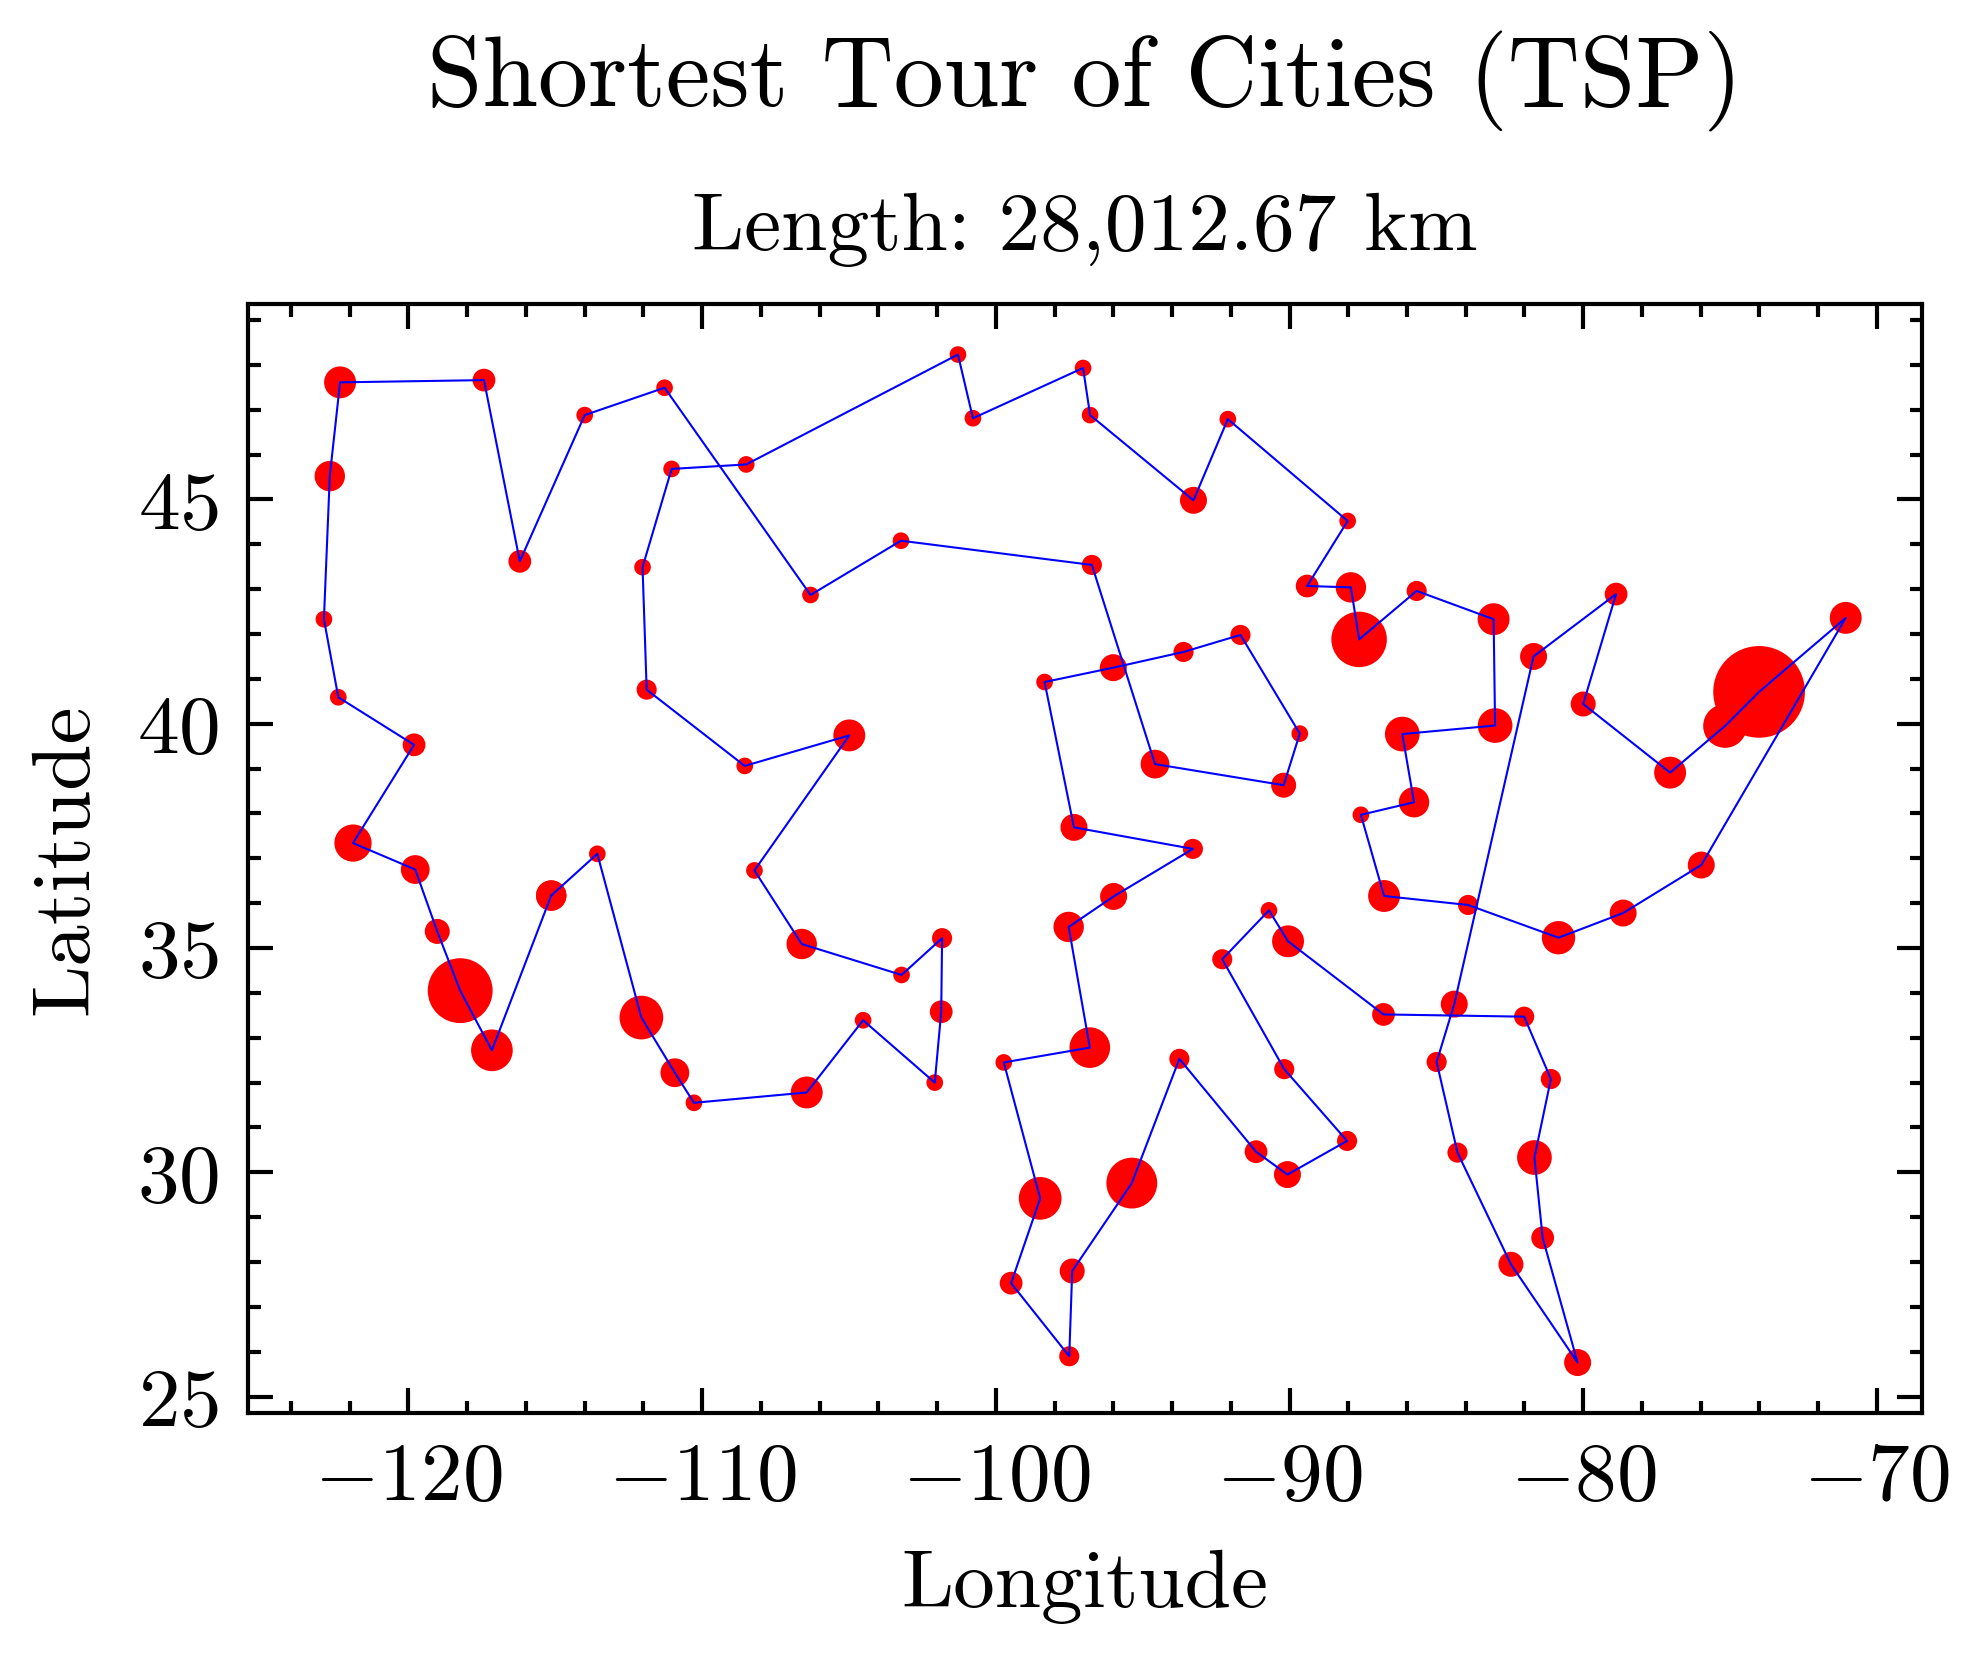

In [508]:
# Plot the best path found
plot_cities_permutation(cities1, best_permutation)

In [ ]:
def load_history(filename):
    with open(filename, "r") as f:
        data = f.read()
    history = []
    for line in data.split("]\n"):
        if not line:
            continue
        generation, fitness, permutation = line.split(" ", 2)
        generation = int(generation)
        fitness = float(fitness)
        # print(permutation[1:-1])
        permutation = list(map(int, list(filter(lambda x: x, re.split(r",?\s", permutation[1:])))))
        history.append((generation, fitness, permutation))
    return history


hist2 = load_history("tmp/geneticalgorithm/20240702-115905/log.txt")

In [ ]:
# def create_animation(cities, permutations, filename="tmp/cities_permutation.mp4", steps_per_frame=6,ease_factor = 2):
#     def interpolate_positions(start_positions, end_positions, alpha, ease_factor):
#         # return start_positions * (1 - alpha) + end_positions * alpha
#         # use ease in out
#         for i in range(ease_factor):
#             alpha = 0.5 - 0.5 * math.cos(alpha * math.pi)
#         return start_positions * (1 - alpha) + end_positions * alpha

#     fig, ax = plt.subplots()
#     fig.set_tight_layout(True)

#     # Pre-plot the cities as scatter points
#     lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
#     min_pop, max_pop = min(pops), max(pops)
#     norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
#     scatter = ax.scatter(lons, lats, s=norm_pops, c="red")

#     # Initialize the line object for updating
#     (line,) = ax.plot([], [], linestyle="-", color="blue", linewidth=0.2)
#     title = ax.text(0.5, 1.13, "City Plot with Permutation Path", transform=ax.transAxes, ha="center", fontsize=12)
#     subtitle = ax.text(0.5, 1.03, "", transform=ax.transAxes, ha="center", fontsize=10)
#     def init():
#         line.set_data([], [])
#         subtitle.set_text("")
#         return line, subtitle

#     def update(frame):
#         start = time.time()

#         frame_num = frame // steps_per_frame
#         alpha = (frame % steps_per_frame) / steps_per_frame

#         p1 = permutations[frame_num]
#         p2 = permutations[min(frame_num + 1, len(permutations) - 1)]

#         cities1 = np.array([cities[i][1:3] for i in p1])
#         cities2 = np.array([cities[i][1:3] for i in p2])

#         interpolated_cities = interpolate_positions(cities1, cities2, alpha, ease_factor)

#         lats, lons = interpolated_cities.T
#         length = path_length(cities, p1)

#         line.set_data(lons, lats)
#         subtitle.set_text(f"Length: {length:.2f}    Generation: {frame_num+1}")

#         end = time.time()
#         if frame % 10 == 0:
#             print(f"Frame {frame} took {end - start:.2e} seconds")
#         return line, subtitle

#     ani = animation.FuncAnimation(
#         fig, update, frames=len(permutations) * steps_per_frame, init_func=init, blit=True, repeat=False
#     )
#     ani.save(filename, writer="ffmpeg", fps=30)
#     plt.close()
#     return filename

In [512]:
def create_animation(cities, permutations, filename="tmp/cities_permutation.mp4", fps=10):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    # Pre-plot the cities as scatter points
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    scatter = ax.scatter(lons, lats, s=norm_pops, c="red")
    
    # Initialize the line object for updating
    line, = ax.plot([], [], linestyle='-', color='blue', linewidth=.25)
    title = ax.text(0.5, 1.18, "Shortest Tour of Cities (TSP)", transform=ax.transAxes, ha="center", fontsize=12)
    subtitle = ax.text(0.5, 1.05, "", transform=ax.transAxes, ha="center", fontsize=10)
    # frame_text = ax.text(0.02, 0.98, "", transform=ax.transAxes, ha="left", va="top", fontsize=10)
    
    def init():
        line.set_data([], [])
        subtitle.set_text("")
        # frame_text.set_text("")
        return line, subtitle

    def update(frame):
        start = time.time()
        gen = permutations[frame]
        p = gen[2]
        p = np.append(p, p[0])
        # print(len(cities), p)
        if any(q >= len(cities) for q in p):
            print(f"Invalid permutation at frame {frame}")
            # find it and print it
            for i, q in enumerate(p):
                if q >= len(cities):
                    print(f"Invalid permutation at index {i}: {q}")
            return line, subtitle
        permuted_cities = [cities[i] for i in p]
        lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
        length = gen[1]
        if not length:
            length = path_length(cities, p, full=True)
        
        line.set_data(lons, lats)
        subtitle.set_text(f"Length: {length:,.2f} km    Generation: {gen[0] + 1}")
        # frame_text.set_text(f"Frame: {frame}")
        
        end = time.time()
        if frame % 10 == 0:
            print(f"Frame {frame} took {end - start:.2e} seconds")
        return line, subtitle

    ani = animation.FuncAnimation(fig, update, frames=len(permutations), init_func=init, blit=True, repeat=False)
    ani.save(filename, writer='ffmpeg', fps=fps)
    plt.close()
    return filename

In [468]:
def test_create_animation():
    permutations = [(i, None, np.random.permutation(len(cities1))) for i in range(6)]
    fn = create_animation(cities1, permutations)
    print(f"Animation created successfully: {fn}")
    # return Video(fn)


test_create_animation()

Frame 0 took 7.88e-04 seconds
Animation created successfully: tmp/cities_permutation.mp4


In [ ]:
# create_animation(cities1, hist[::10], filename="tmp/geneticalgorithm/cities_permutation.mp4")

Frame 0 took 1.00e-03 seconds


'tmp/geneticalgorithm/cities_permutation.mp4'

In [510]:
def filter_history(hist):
    hist_filtered = hist[:1]
    for h in hist:
        if not list(h[2]) == list(hist_filtered[-1][2]):
            hist_filtered.append(h)
    return hist_filtered

# hist2_filtered = filter_history(hist2)
# len(hist2), len(hist2_filtered)
hist_filtered = filter_history(hist)
len(hist), len(hist_filtered)

(11400, 195)

In [518]:
# create_animation(cities1, hist2_filtered, filename="tmp/geneticalgorithm/cities_permutation_filtered.mp4")
create_animation(cities1, hist_filtered, filename="tmp/geneticalgorithm/cities_permutation_filtered.mp4", fps=9)

Frame 0 took 1.81e-03 seconds
Frame 10 took 1.67e-04 seconds
Frame 20 took 2.00e-04 seconds
Frame 30 took 4.12e-04 seconds
Frame 40 took 1.02e-03 seconds
Frame 50 took 1.98e-04 seconds
Frame 60 took 5.45e-04 seconds
Frame 70 took 5.41e-04 seconds
Frame 80 took 1.71e-04 seconds
Frame 90 took 1.76e-04 seconds
Frame 100 took 1.51e-04 seconds
Frame 110 took 1.66e-04 seconds
Frame 120 took 1.08e-03 seconds
Frame 130 took 2.64e-02 seconds
Frame 140 took 1.69e-04 seconds
Frame 150 took 6.79e-04 seconds
Frame 160 took 9.90e-04 seconds
Frame 170 took 1.01e-03 seconds
Frame 180 took 1.58e-04 seconds
Frame 190 took 1.59e-04 seconds


'tmp/geneticalgorithm/cities_permutation_filtered.mp4'

In [ ]:
create_animation(
    cities1,
    hist_filtered[::20],
    filename="tmp/geneticalgorithm/cities_permutation_filtered_interpolated.mp4",
    steps_per_frame=5,
    ease_factor=2,
)

Frame 0 took 8.21e-04 seconds
Frame 10 took 5.33e-04 seconds
Frame 20 took 5.51e-04 seconds
Frame 30 took 2.20e-04 seconds
Frame 40 took 2.44e-04 seconds


'tmp/geneticalgorithm/cities_permutation_filtered_interpolated.mp4'

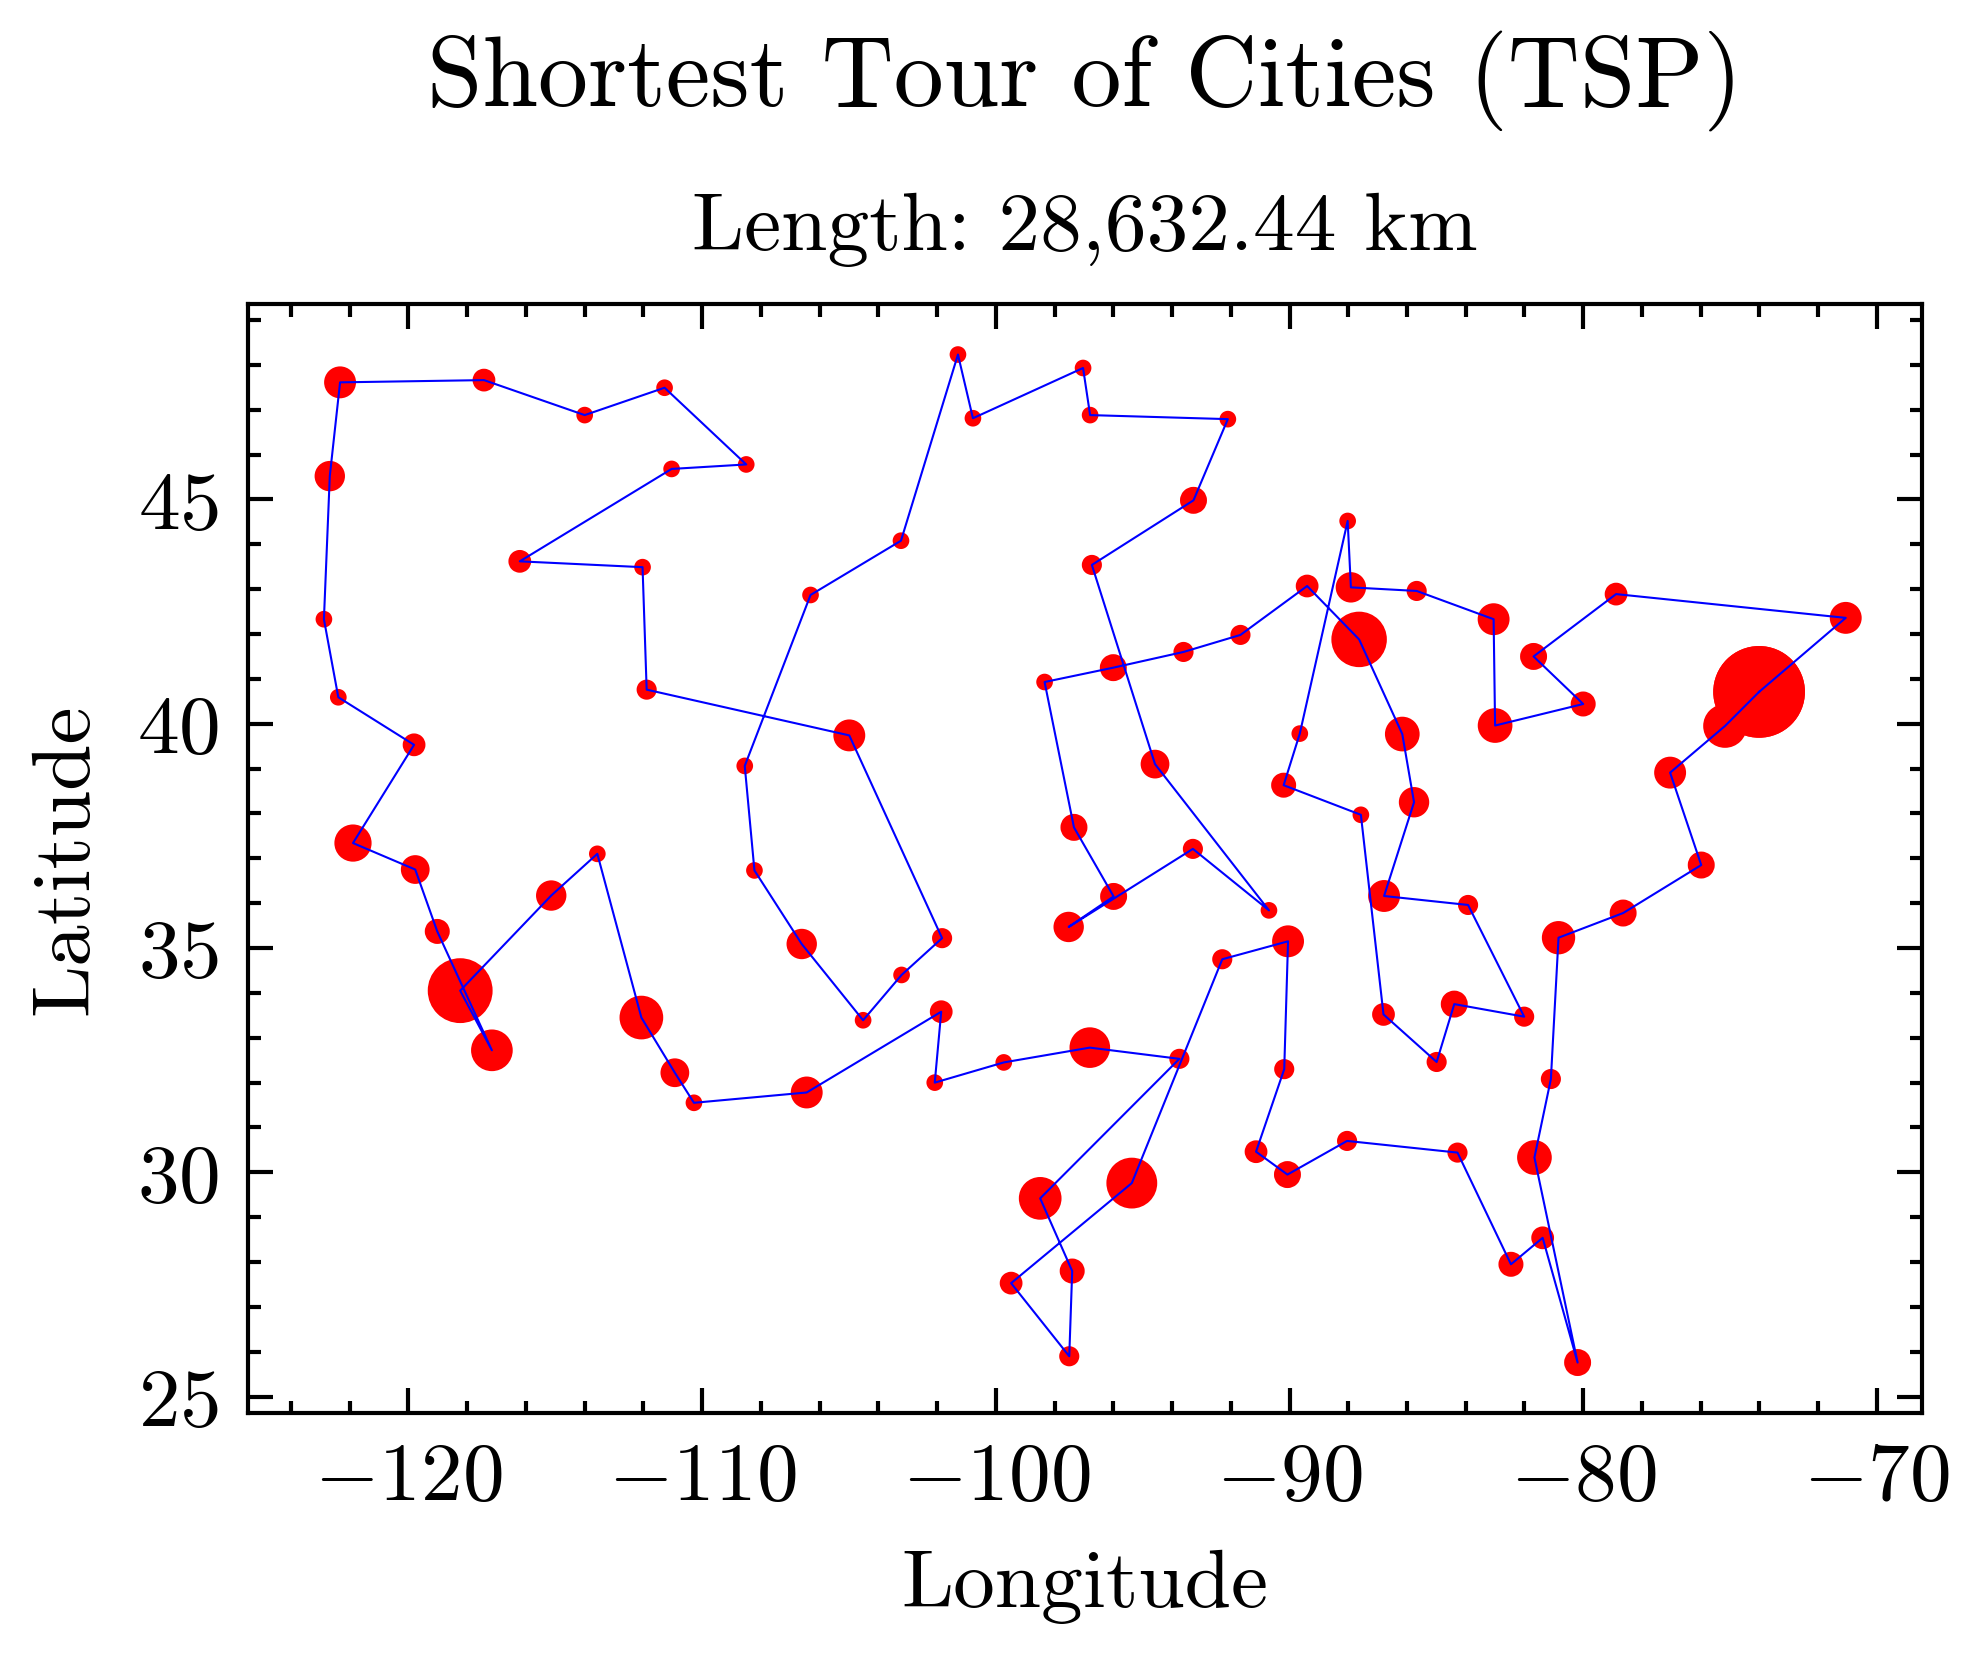

In [504]:
# Christofides algorithm implementation
def christofides(cities):
    # Create a complete graph with distances as edge weights
    G = nx.Graph()
    for i, c1 in enumerate(cities):
        for j, c2 in enumerate(cities):
            if i != j:
                G.add_edge(i, j, weight=distance(c1[1], c1[2], c2[1], c2[2]))

    # Step 1: Find the Minimum Spanning Tree (MST)
    MST = nx.minimum_spanning_tree(G)

    # Step 2: Find the vertices with odd degree in the MST
    odd_degree_nodes = [v for v, d in MST.degree() if d % 2 == 1]

    # Step 3: Find the minimum weight perfect matching for the odd degree vertices
    odd_subgraph = G.subgraph(odd_degree_nodes)
    matching = nx.algorithms.matching.min_weight_matching(odd_subgraph)

    # Combine the matching and the MST to form a multigraph
    multigraph = nx.MultiGraph()
    multigraph.add_edges_from(MST.edges)
    multigraph.add_edges_from(matching)

    # Step 4: Form an Eulerian circuit from the multigraph
    eulerian_circuit = list(nx.eulerian_circuit(multigraph))

    # Step 5: Create a Hamiltonian circuit by shortcutting repeated vertices
    visited = set()
    path = []
    for u, v in eulerian_circuit:
        if u not in visited:
            visited.add(u)
            path.append(u)
    path.append(path[0])  # Closing the loop

    return path

# Run the Christofides algorithm
best_path = christofides(cities1)
best_length = path_length(cities1, best_path, full=True)

# Plot the best path found
plot_cities_permutation(cities1, best_path)

Running genetic_algorithm with parameters: {'population_size': 1000, 'generations': 1000, 'mutation_rate': 0.0003, 'mutation_decay_factor': 1, 'r': 0.1, 'full': True, 'initial_population': [[0, 13, 45, 83, 68, 33, 36, 82, 61, 81, 92, 31, 89, 41, 80, 27, 58, 69, 29, 73, 20, 3, 88, 86, 55, 34, 95, 63, 72, 32, 64, 94, 16, 43, 17, 59, 28, 97, 37, 76, 38, 75, 78, 77, 23, 65, 91, 66, 7, 25, 71, 15, 79, 22, 53, 48, 19, 4, 40, 87, 93, 70, 8, 49, 84, 44, 1, 18, 85, 6, 46, 96, 10, 26, 57, 90, 21, 54, 24, 35, 47, 51, 2, 50, 11, 67, 98, 14, 60, 62, 30, 99, 9, 5, 74, 12, 52, 42, 39, 56], [0, 13, 45, 83, 68, 33, 36, 82, 61, 81, 92, 31, 89, 41, 80, 27, 58, 69, 29, 73, 20, 3, 88, 86, 55, 34, 95, 63, 72, 32, 64, 94, 16, 43, 17, 59, 28, 97, 37, 76, 38, 75, 78, 77, 23, 65, 91, 66, 7, 25, 71, 15, 79, 22, 53, 48, 19, 4, 40, 87, 93, 70, 8, 49, 84, 44, 1, 18, 85, 6, 46, 96, 10, 26, 57, 90, 21, 54, 24, 35, 47, 51, 2, 50, 11, 67, 98, 14, 60, 62, 30, 99, 9, 5, 74, 12, 52, 42, 39, 56], [0, 13, 45, 83, 68, 33, 36

  0%|          | 0/1000 [00:00<?, ?it/s]

Generation 21/1000 (Fitness: 27916.90 - 41646.94 - 29410.24):   2%|▏         | 20/1000 [00:06<04:01,  4.06it/s]

Generation 41/1000 (Fitness: 27256.85 - 41865.29 - 28479.74):   4%|▍         | 40/1000 [00:11<04:21,  3.67it/s]

Generation 60/1000 (Fitness: 27084.36 - 37909.51 - 27929.42):   6%|▌         | 59/1000 [00:15<03:41,  4.26it/s]

Generation 81/1000 (Fitness: 27084.36 - 36540.97 - 27276.52):   8%|▊         | 80/1000 [00:21<03:37,  4.23it/s]

Generation 101/1000 (Fitness: 27084.36 - 38430.33 - 27300.76):  10%|█         | 100/1000 [02:38<1:43:40,  6.91s/it]

Generation 121/1000 (Fitness: 27084.36 - 42179.17 - 27288.42):  12%|█▏        | 120/1000 [02:43<03:40,  3.99it/s]  

Generation 141/1000 (Fitness: 27084.36 - 38599.63 - 27329.76):  14%|█▍        | 140/1000 [02:48<03:27,  4.15it/s]

Generation 155/1000 (Fitness: 27084.36 - 38512.01 - 27484.34):  15%|█▌        | 154/1000 [02:52<15:45,  1.12s/it]



Early stopping at generation 155


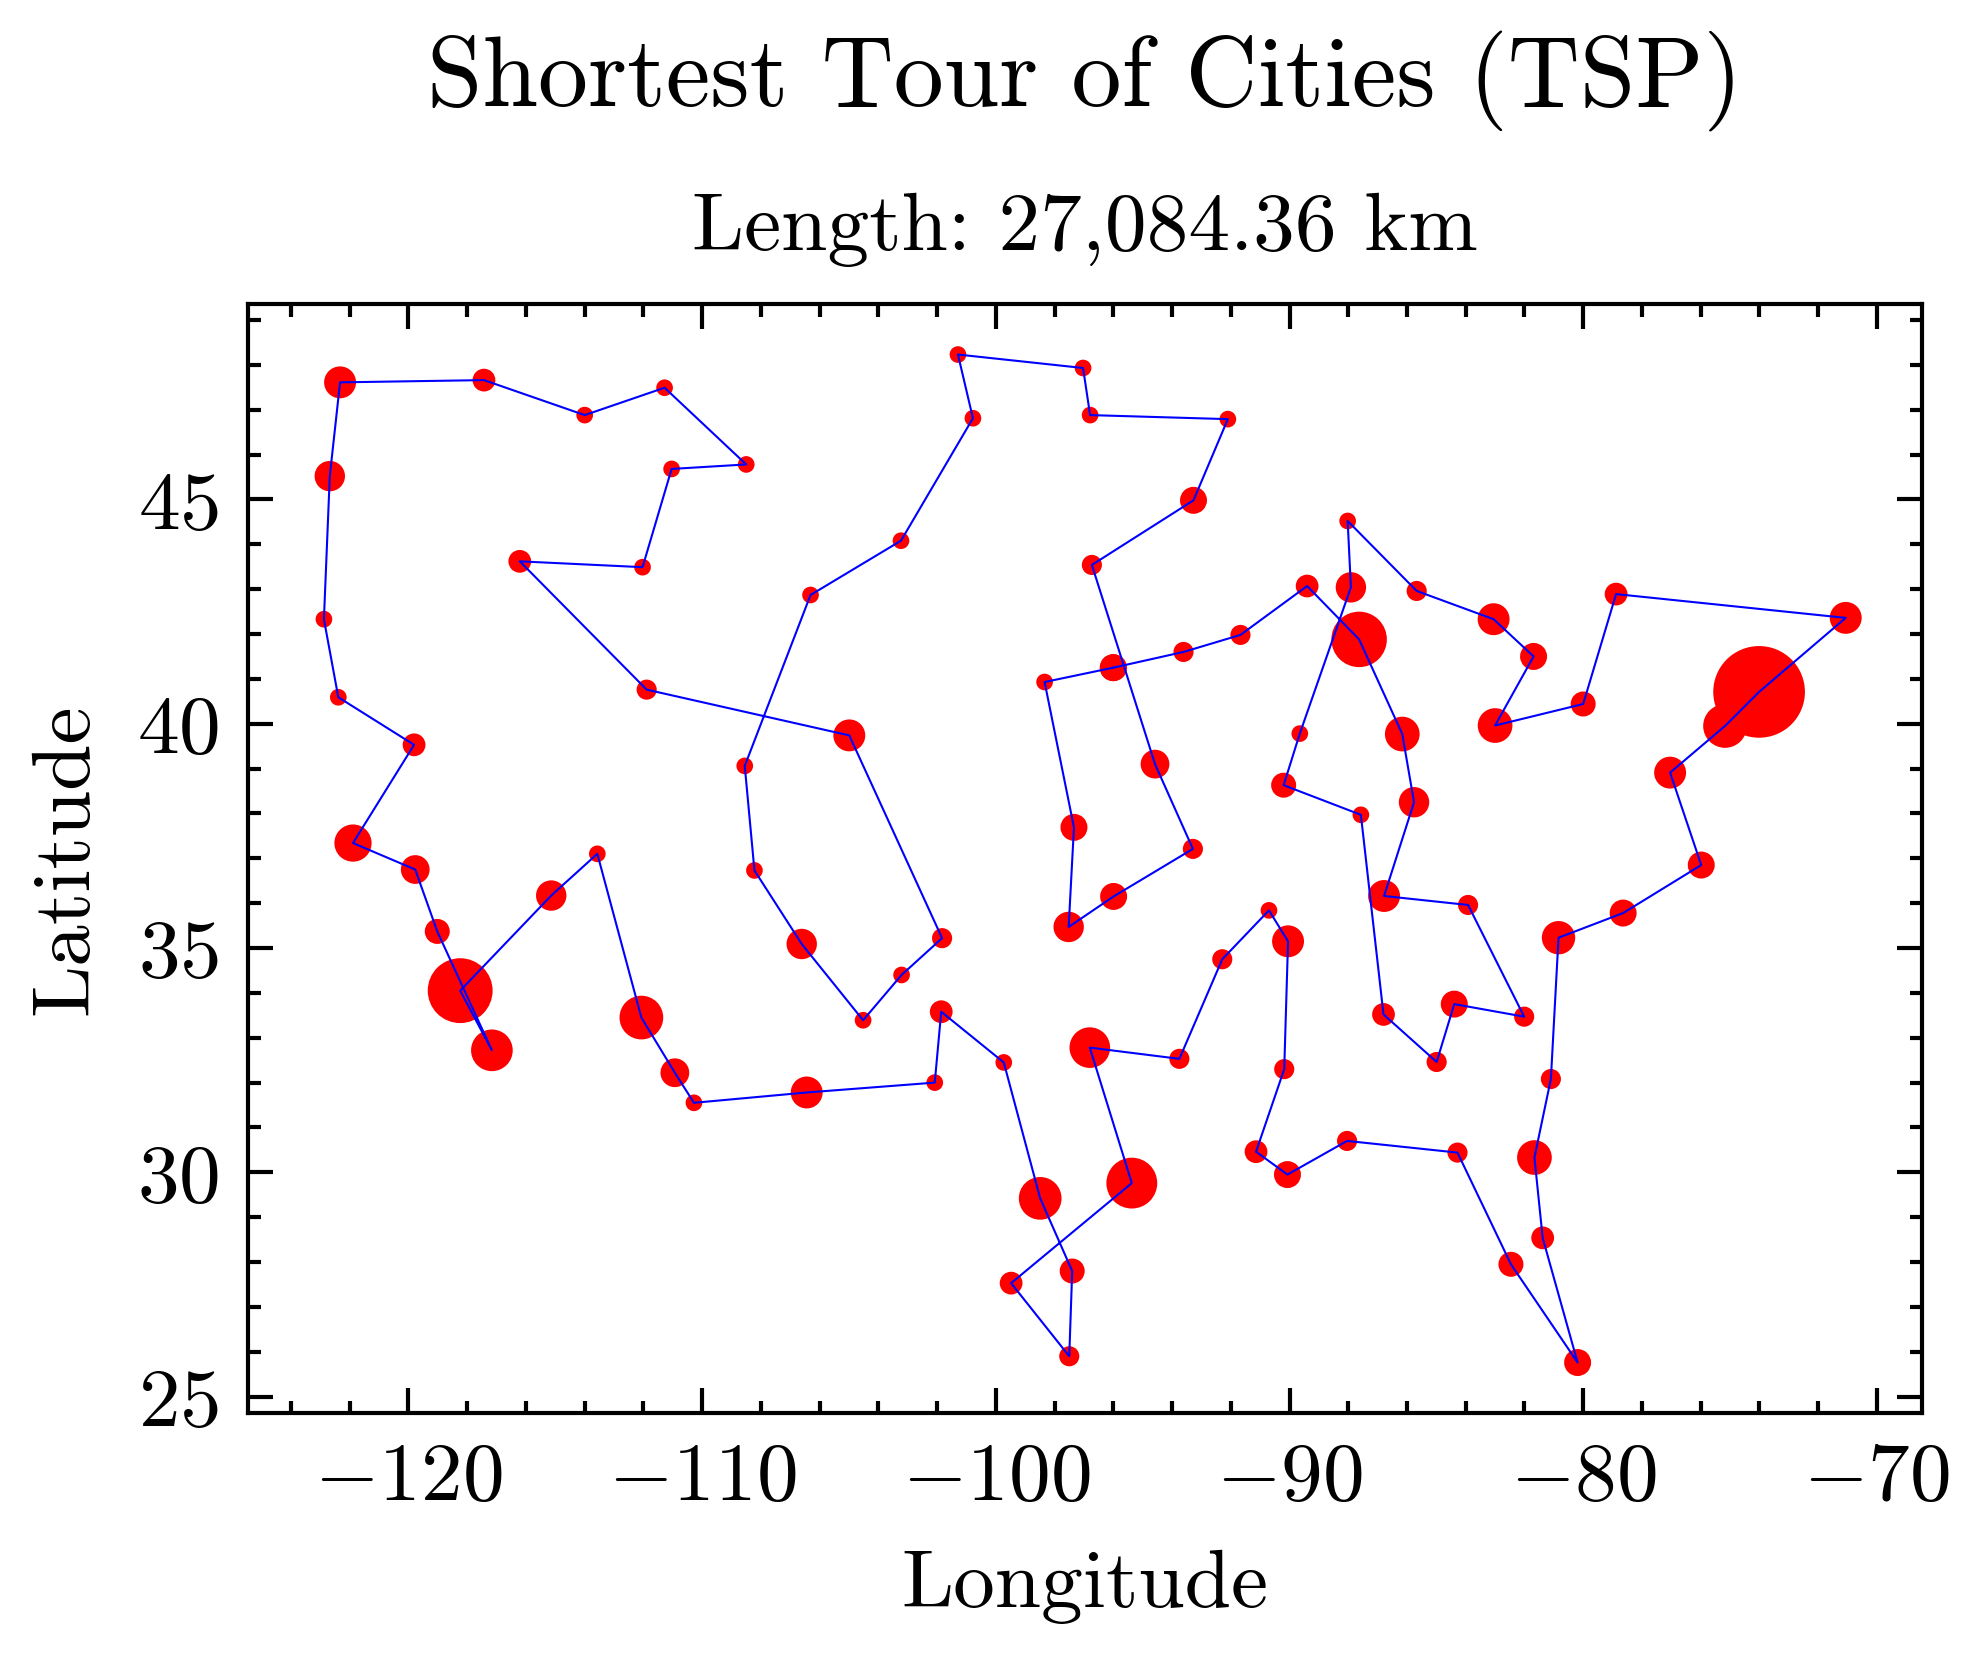

In [506]:
best_permutation, best_length, hist1 = genetic_algorithm(
    cities1,
    mutation_rate=3e-4,
    generations=1000,
    r=0.1,
    population_size=1000,
    early_stopping_generations=100,
    initial_population=[best_path[:-1]]*90,
    cpu_count=10000
)

# Plot the best path found
plot_cities_permutation(cities1, best_permutation)

In [ ]:
print(best_permutation, best_length)

[13, 188, 115, 129, 45, 109, 169, 68, 83, 36, 153, 100, 156, 82, 3, 149, 88, 61, 81, 170, 161, 191, 111, 17, 59, 28, 97, 76, 37, 38, 75, 145, 7, 128, 179, 183, 23, 77, 78, 25, 113, 15, 71, 79, 22, 53, 48, 19, 139, 136, 4, 40, 117, 162, 87, 93, 194, 70, 110, 8, 187, 49, 197, 84, 172, 176, 1, 44, 122, 152, 18, 85, 104, 6, 46, 96, 143, 10, 65, 91, 66, 26, 57, 125, 90, 148, 32, 193, 63, 196, 166, 195, 95, 190, 34, 105, 43, 55, 86, 173, 171, 92, 163, 20, 177, 33, 141, 102, 73, 181, 29, 165, 89, 159, 31, 182, 108, 16, 64, 72, 106, 50, 94, 11, 116, 103, 41, 140, 80, 131, 160, 27, 133, 58, 135, 120, 74, 5, 107, 99, 186, 130, 9, 123, 30, 158, 62, 147, 134, 144, 60, 124, 150, 67, 114, 155, 54, 175, 174, 21, 121, 24, 51, 185, 47, 35, 142, 101, 168, 2, 127, 180, 154, 98, 14, 146, 167, 138, 69, 199, 119, 12, 126, 52, 189, 112, 157, 132, 118, 164, 151, 42, 39, 56, 198, 0, 178, 137, 184, 192, 13] 32937.791375092864


In [ ]:
len(best_permutation)

201

In [ ]:
def test_blocks():
    cities = [(f"C{i+1}", i // 6, i % 6, 10) for i in range(6**2)]
    plot_cities_permutation(
        cities,
        genetic_algorithm(
            cities,
            mutation_rate=3e-4,
            mutation_decay_factor=0.1 ** (1 / 1000),
            generations=1000,
            population_size=5000,
            early_stopping_generations=200,
        )[0]
    )
    plot_cities_permutation(cities, christofides(cities))

test_blocks()